In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from rapidfuzz import fuzz

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.decomposition import PCA
import matplotlib.ticker as mticker
import math
#import umap.umap_ as umap

In [9]:
df = pd.read_csv('../data/titles_metadata_250702.csv', index_col=0)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.head(6391)
df.shape

(6391, 9)

In [10]:
# number of unique book advertisements
df['article_id'].nunique()

3705

In [ ]:
# top 20 most frequently advertised book titles
df.groupby(['author', 'cluster_label', 'category']).size().reset_index(name='count').sort_values(by='count', ascending=False).head(20)

,author,cluster_label,category,count
60,A. F. Just,Haandbog for den læsende Ungdom,Education and Bildung,55
540,C. Jacobsen,Nye Kogebog,"Agriculture, household and artisanship",46
977,F. Munthe,De vigtigste indenlandske Tildragelser og de m...,"History, philosophy and biographies",34
3827,Schou,Udtog af Forordninger,"Law, politics and government",27
69,A. F. Just,Naturhistorie,"Geography, topography and biology",25
26,A. F. Elmquist,Læsefrugter samlede paa Litteraturens Mark,Subscription journals,25
3543,P. O. Boisen,Bibelske Fortællinger med Anvendelse paa Relig...,"Religion, theology and psalms",21
976,F. Munthe,De mærkeligste Personers Levnetsbeskrivelse og...,"History, philosophy and biographies",18
498,C. F. Schulz,"Den lystige Lollænder, eller nyeste Samling af...",Almanacs and other light readings,17
1240,H. J. Birch,Bibelhistorie,"Religion, theology and psalms",17


In [ ]:
# authors that appear only once
df['author'].value_counts().eq(1).sum()

1049

In [6]:
# Exclude 'NO_AUTHOR'
filtered_df = df[df['author'] != 'NO_AUTHOR']

# Count mentions per author
filtered_df['author'].value_counts()

author
A. F. Just             144
Adam Oehlenschläger     81
J. L. Heiberg           81
A. F. Elmquist          75
A. von Kotzebue         67
                      ... 
Pastor Daugaard          1
P. Z. Anden              1
P. v. Gerschau           1
P. T. Hald               1
Niels Starup             1
Name: count, Length: 1705, dtype: int64

In [63]:
# number of unique book titles
df['cluster_label'].nunique()

3808

In [7]:
cat_names = df['category'].unique().tolist()

In [61]:
df['category'].value_counts()

category
Theatre, music and poems                  1310
Education and Bildung                      840
Religion, theology and psalms              811
Literature and personal writings           800
History, philosophy and biographies        609
Agriculture, household and artisanship     561
Law, politics and government               440
Almanacs and other light readings          431
Unknown                                    206
Subscription journals                      200
Geography, topography and biology          183
Name: count, dtype: int64

In [89]:
# Step 1: Count how many newspapers each book appears in
newspaper_counts = (
    df.groupby(['author', 'cluster_label'])['newspaper']
    .nunique()
    .reset_index(name='num_newspapers')
)

# Step 2: Keep only books that appear in 2 or more different newspapers
multi_newspaper_books = newspaper_counts[newspaper_counts['num_newspapers'] >= 2]

# Step 3: Merge back to get full rows for those books
df_multi = df.merge(
    multi_newspaper_books[['author', 'cluster_label']],
    on=['author', 'cluster_label'],
    how='inner'
)

# Step 4: Get the first ad for each book
first_mentions = (
    df_multi.sort_values('date')
    .groupby(['author', 'cluster_label'])
    .first()
    .reset_index()
)

# Step 5: Count how often each newspaper is the first to advertise
first_newspaper_counts = first_mentions['newspaper'].value_counts().reset_index()
first_newspaper_counts.columns = ['newspaper', 'count']

print(first_newspaper_counts)

  newspaper  count
0       ode    128
1       aar     94
2       aal     84
3       vib     70
4       lol     52
5       thi     33


In [119]:
first_newspaper_counts.sum()

newspaper    odeaaraalviblolthi
count                       461
dtype: object

In [102]:
# Step 1: For each (author, title), get the newspapers ordered by date
ad_paths = (
    df.sort_values('date')
    .groupby(['author', 'cluster_label'])['newspaper']
    .apply(lambda x: tuple(pd.unique(x)))  # keep order, remove duplicates
    .reset_index(name='path')
)

# Step 2: Count how often each unique path occurs
path_counts = ad_paths['path'].value_counts().reset_index()
path_counts.columns = ['path', 'count']

# Keep only paths with at least two different newspapers
multi_step_paths = path_counts[path_counts['path'].apply(len) >= 2].reset_index(drop=True)

In [ ]:
edge_rows = []

for _, row in multi_step_paths.iterrows():
    path = row['path']
    count = row['count']
    path_id = "_".join(path)
    for i in range(len(path) - 1):
        edge_rows.append({
            'Source': path[i],
            'Target': path[i + 1],
            'Weight': count,
            'PathID': path_id
        })

edges_df = pd.DataFrame(edge_rows)
edges_df.to_csv('../data/edges.csv', index=False)

In [ ]:
unique_nodes = set()
for path in multi_step_paths['path']:
    unique_nodes.update(path)

nodes_df = pd.DataFrame({'Id': sorted(unique_nodes)})
nodes_df['Label'] = nodes_df['Id']
nodes_df.to_csv('../data/nodes.csv', index=False)

#### Category sizes

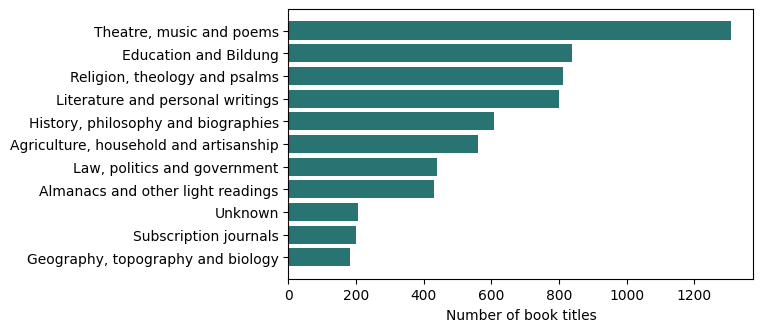

In [53]:
grouped1 = df['category'].value_counts()

fig, axs = plt.subplots(figsize=(6, 3.5))

axs.barh(range(len(grouped1)), grouped1.values[::-1], color='#297373')
axs.set_xlabel('Number of book titles')
axs.set_yticks(range(len(grouped1)))
axs.set_yticklabels(grouped1.index[::-1], ha='right')
#plt.title('Size of topic categories')
#plt.tight_layout()
plt.savefig('../figures/cat_sizes.pdf', bbox_inches='tight')
plt.show()

#### Normalized category distributions per newspaper

/var/folders/dt/1462j2zd19q_2sh2_66j7_8m6l1brz/T/ipykernel_8169/1214893282.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Aalborg', 'Aarhus', 'Maribo', 'Odense', 'Thisted', 'Viborg'], ha='center')


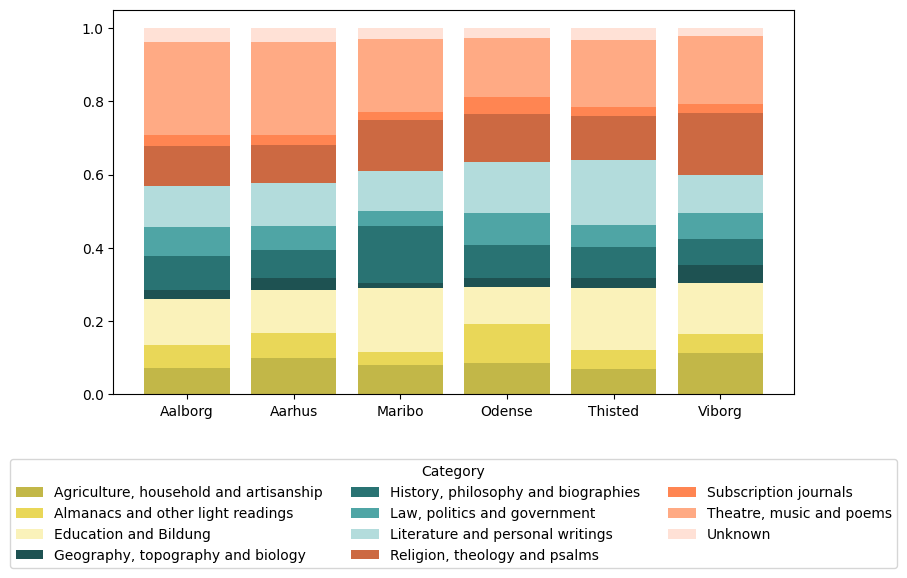

In [4]:
# Group and count categories per newspaper
grouped = df.groupby(['newspaper', 'category']).size().unstack(fill_value=0)

# Normalize each row (per newspaper)
normalized = grouped.div(grouped.sum(axis=1), axis=0)

# Get a list of colors from the 'Paired' palette
custom_palette = [
    '#C2B748', '#E9D758', '#FAF2BA', #'#F2E480', #'#FAF2BA',  # yellows
    '#1E5252', '#297373', '#4FA5A5', '#B3DCDC',  # teals
    '#CC6942', '#FF8552', '#FFAA84', '#FFE1D6'   # corals
]

# Map categories to colors
category_to_color = dict(zip(normalized.columns, custom_palette))

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

bottom = np.zeros(len(normalized))
for category in normalized.columns:
    ax.bar(
        normalized.index,
        normalized[category],
        bottom=bottom,
        label=category,
        color=category_to_color[category]
    )
    bottom += normalized[category]

#ax.set_ylabel("Proportion of Articles")
#ax.set_title("Normalized Category Distribution per Newspaper")
ax.set_xticklabels(['Aalborg', 'Aarhus', 'Maribo', 'Odense', 'Thisted', 'Viborg'], ha='center')

# One shared legend at the bottom
ax.legend(title="Category", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
#plt.savefig('../figures/norm_cats_newspapers.pdf', bbox_inches='tight')
plt.show()

In [50]:
normalized.to_csv('../data/matrix.csv')

### Comparison to author baseline

In [54]:
authors_baseline = pd.read_excel('../data/authors_baseline.xlsx')
authors_baseline.head()

,last_name,first_name,Unnamed: 2
0,a Fincke,Matthæus,NaN
1,Aabye,Thomas,NaN
2,Aagaard,Andreas Jensen,NaN
3,Aagaard,Christen Lauridsen,NaN
4,Aagaard,Christen Rømer,NaN


In [57]:
authors_baseline['full_name'] = authors_baseline['first_name'] + ' ' + authors_baseline['last_name']

In [58]:
authors_baseline.head()

,last_name,first_name,Unnamed: 2,full_name
0,a Fincke,Matthæus,NaN,Matthæus a Fincke
1,Aabye,Thomas,NaN,Thomas Aabye
2,Aagaard,Andreas Jensen,NaN,Andreas Jensen Aagaard
3,Aagaard,Christen Lauridsen,NaN,Christen Lauridsen Aagaard
4,Aagaard,Christen Rømer,NaN,Christen Rømer Aagaard


In [66]:
df['author'].nunique()

1706

In [75]:
def clean_name(name):
    """Normalize whitespace and casing"""
    return re.sub(r'\s+', ' ', name).strip().lower()

def extract_initials_and_surname(name):
    """Extract initials and surname from abbreviated name"""
    parts = name.strip().split()
    initials = [p[0] for p in parts if '.' in p]
    surname = parts[-1]
    return initials, clean_name(surname)

def match_name(query, full_name, fuzzy_threshold=80, surname_threshold=80):
    if not isinstance(query, str) or not isinstance(full_name, str):
        return False

    query = clean_name(query)
    full_name = clean_name(full_name)

    query_parts = query.split()
    full_parts = full_name.split()

    full_surname = full_parts[-1]
    full_given = full_parts[:-1]

    # Case 1: only surname
    if len(query_parts) == 1:
        score = fuzz.ratio(query, full_surname)
        return score >= surname_threshold

    # Case 2: initials + surname
    if any('.' in p for p in query_parts):
        initials, query_surname = extract_initials_and_surname(query)
        if len(initials) > len(full_given):
            return False
        # initials must match exactly
        if not all(full_given[i].startswith(initials[i]) for i in range(len(initials))):
            return False
        # fuzzy match on surname
        score = fuzz.ratio(query_surname, full_surname)
        return score >= surname_threshold

    # Case 3: full name → fuzzy match on full name
    similarity = fuzz.token_sort_ratio(query, full_name)
    return similarity >= fuzzy_threshold

In [76]:
author_list = authors_baseline['full_name'].dropna().tolist()
df['author'] = df['author'].fillna('')

df['is_match'] = df['author'].apply(
    lambda x: any(match_name(x, name) for name in author_list)
)

# Optional: get number of matches
num_matches = df['is_match'].sum()
print(f"{num_matches} out of {len(df)} authors matched.")

3175 out of 6391 authors matched.


In [77]:
df.groupby('is_match')['author'].nunique()

is_match
False    851
True     855
Name: author, dtype: int64

### Book titles per month

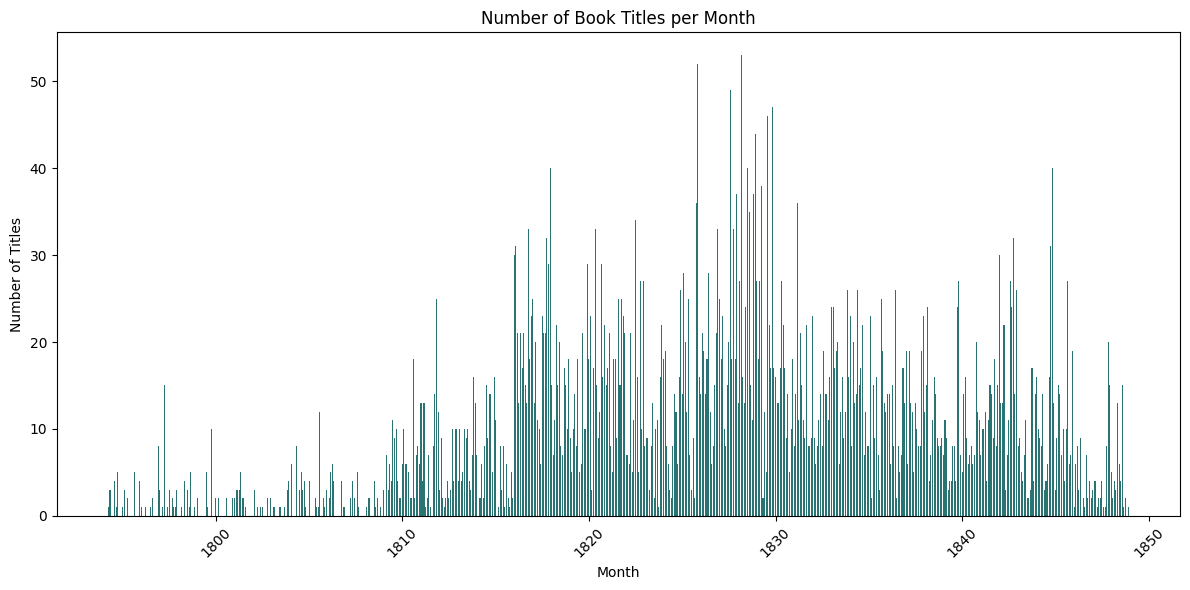

In [5]:
# Ensure 'date' column is datetime
df['date'] = pd.to_datetime(df['date'])

# Create 'month' column (year + month only)
df['month'] = df['date'].dt.to_period('M')

# Count number of titles per month
monthly_counts = df.groupby('month').size()

# Convert PeriodIndex to datetime for plotting
monthly_counts.index = monthly_counts.index.to_timestamp()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(monthly_counts.index, monthly_counts.values, width=20, color='#297373')
#plt.xlim(pd.to_datetime('1824-01-01'), pd.to_datetime('1838-12-31'))
plt.xlabel('Month')
plt.ylabel('Number of Titles')
plt.title('Number of Book Titles per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Longevity of books and authors

In [11]:
# Group by title and calculate min and max date
date_spans = df.groupby('cluster_label')['date'].agg(['min', 'max'])

# Calculate the number of days between first and last mention
date_spans['days_between'] = (date_spans['max'] - date_spans['min']).dt.days

# Optional: sort by longest running titles
date_spans = date_spans.sort_values(by='days_between', ascending=False)

In [12]:
date_spans.head(30)

,min,max,days_between
cluster_label,,,
Digte,1794-08-30,1840-10-23,16855
Naturhistorie,1796-12-07,1842-11-17,16780
Nyeaarsgave for 1797,1797-01-04,1836-12-27,14601
Geometrie,1797-04-29,1835-06-04,13914
Bibliothek for Læger,1809-08-24,1847-02-18,13692
Psalmebog,1803-11-16,1840-04-22,13307
Huuspostil,1811-03-05,1847-06-15,13251
Psalmebøger,1809-01-07,1842-09-17,12306
Haandbog for den læsende Ungdom,1800-03-12,1833-08-16,12210


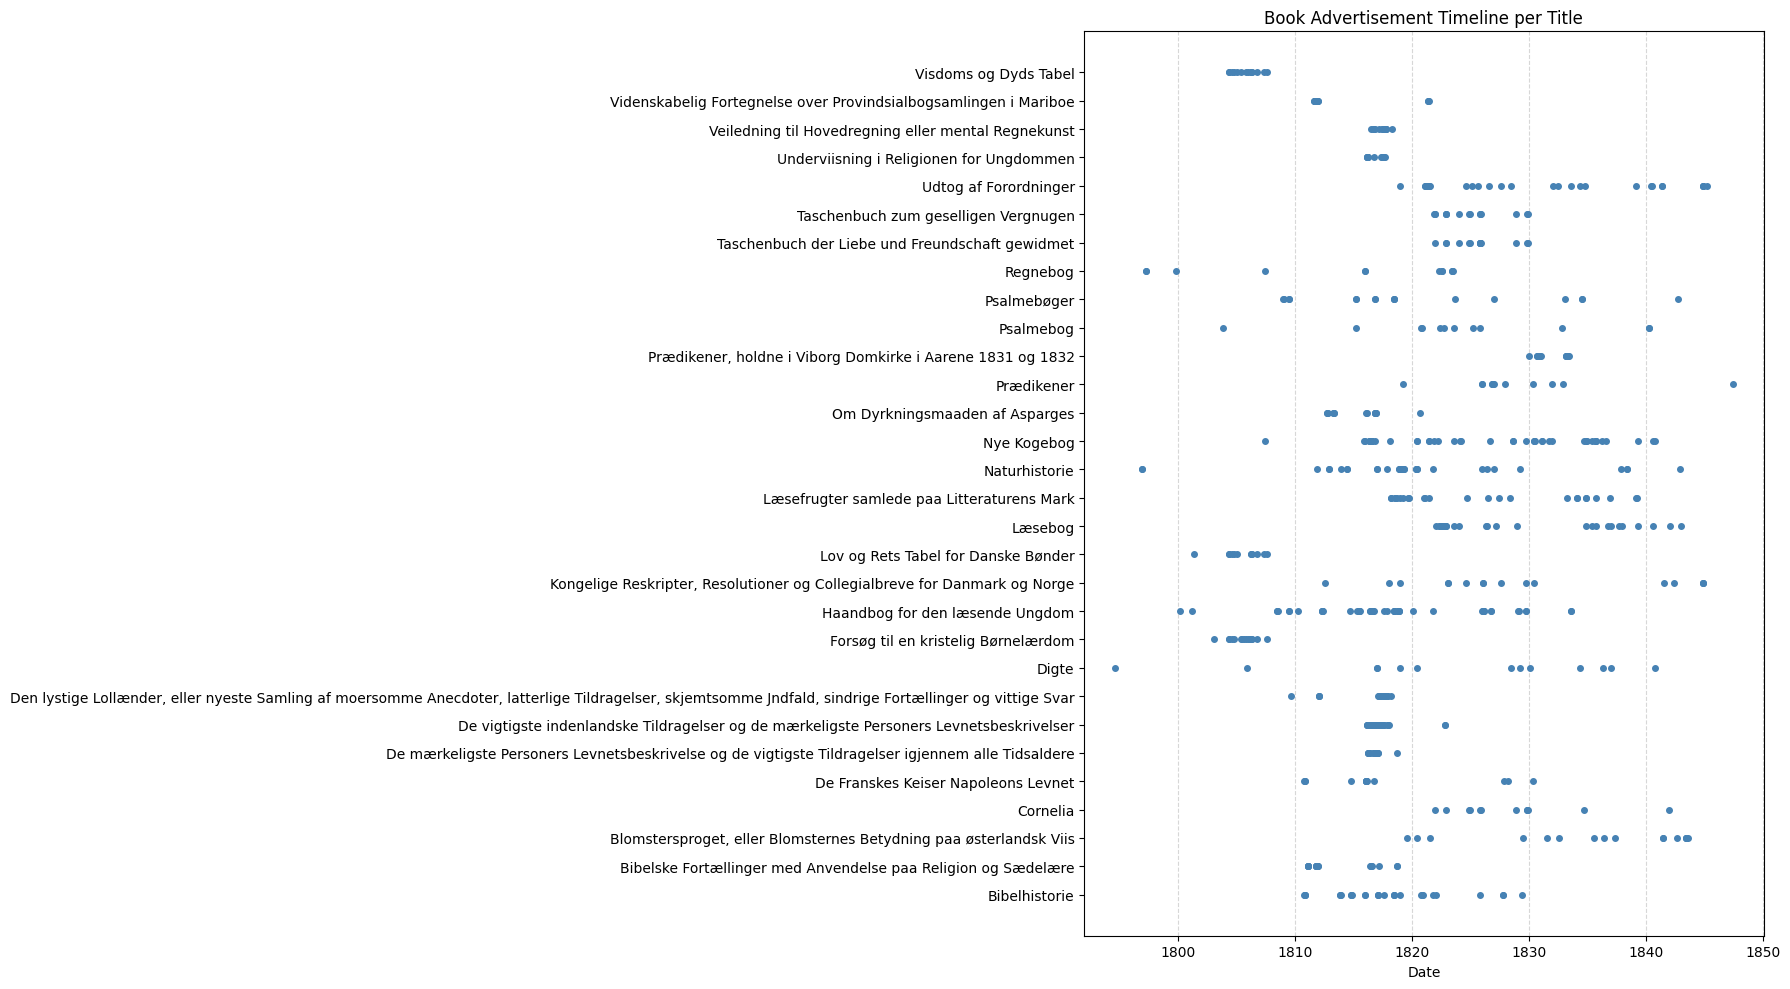

In [18]:
# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Optional: limit to top N most advertised books for clarity
top_titles = df['cluster_label'].value_counts().head(30).index
df_subset = df[df['cluster_label'].isin(top_titles)].copy()

# Sort titles for consistent vertical positioning
title_order = sorted(df_subset['cluster_label'].unique())
title_to_y = {title: i for i, title in enumerate(title_order)}

# Create the plot
plt.figure(figsize=(18, 10))

# Plot each appearance as a dot
for _, row in df_subset.iterrows():
    y = title_to_y[row['cluster_label']]
    plt.plot(row['date'], y, 'o', color='steelblue', markersize=4)

# Customize axes
plt.yticks(range(len(title_order)), title_order)
plt.xlabel('Date')
plt.title('Book Advertisement Timeline per Title')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
# Group by title and category → get min and max date per title
lifespans = df.groupby(['cluster_label', 'category'])['date'].agg(['min', 'max'])

# Compute number of days between first and last mention
lifespans['lifespan_days'] = (lifespans['max'] - lifespans['min']).dt.days + 1

# Group by category and compute average lifespan
avg_lifespan_per_category = lifespans.groupby('category')['lifespan_days'].mean().round(1)

# Display result
print(avg_lifespan_per_category)

category
Agriculture, household and artisanship    415.0
Almanacs and other light readings         586.4
Education and Bildung                     572.7
Geography, topography and biology         452.7
History, philosophy and biographies       193.7
Law, politics and government              343.9
Literature and personal writings          221.4
Religion, theology and psalms             603.1
Subscription journals                     542.3
Theatre, music and poems                  499.6
Unknown                                    36.7
Name: lifespan_days, dtype: float64


#### Per book title

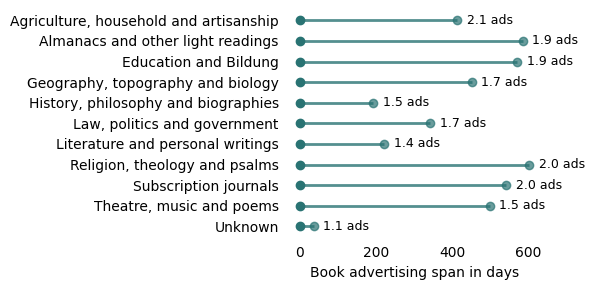

In [60]:
# Group by title and category
grouped = df.groupby(['cluster_label', 'category'])

# Calculate lifespan and ad count per book
book_stats = grouped['date'].agg(['min', 'max', 'count']).reset_index()
book_stats['lifespan'] = (book_stats['max'] - book_stats['min']).dt.days

# Average per category
category_stats = book_stats.groupby('category').agg(
    avg_lifespan=('lifespan', 'mean'),
    avg_ads=('count', 'mean')
).reset_index()

# Sort categories for clear plot
category_stats = category_stats.sort_values(by='category', ascending=False).reset_index(drop=True)

# Plot
fig, ax = plt.subplots(figsize=(6, 3))

for i, row in category_stats.iterrows():
    y = i
    ax.hlines(y, 0, row['avg_lifespan'], color='#297373', linewidth=2, linestyles='solid', alpha=0.8)
    ax.plot(0, y, 'o', color='#297373')  # Start at 0
    ax.plot(row['avg_lifespan'], y, 'o', color='#297373', alpha=0.7)  # End at lifespan
    ax.text(row['avg_lifespan'] + 15, y, f" {row['avg_ads']:.1f} ads", va='center', fontsize=9)

# Labels and formatting
ax.set_yticks(range(len(category_stats)))
ax.set_yticklabels(category_stats['category'])
ax.set_xlabel("Book advertising span in days")
#ax.set_title("Average Book Lifespan per Category\n(Green = first appearance, Red = last)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False)
ax.tick_params(bottom=False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
#plt.savefig('../figures/lifespan_books.pdf', bbox_inches='tight')
plt.show()

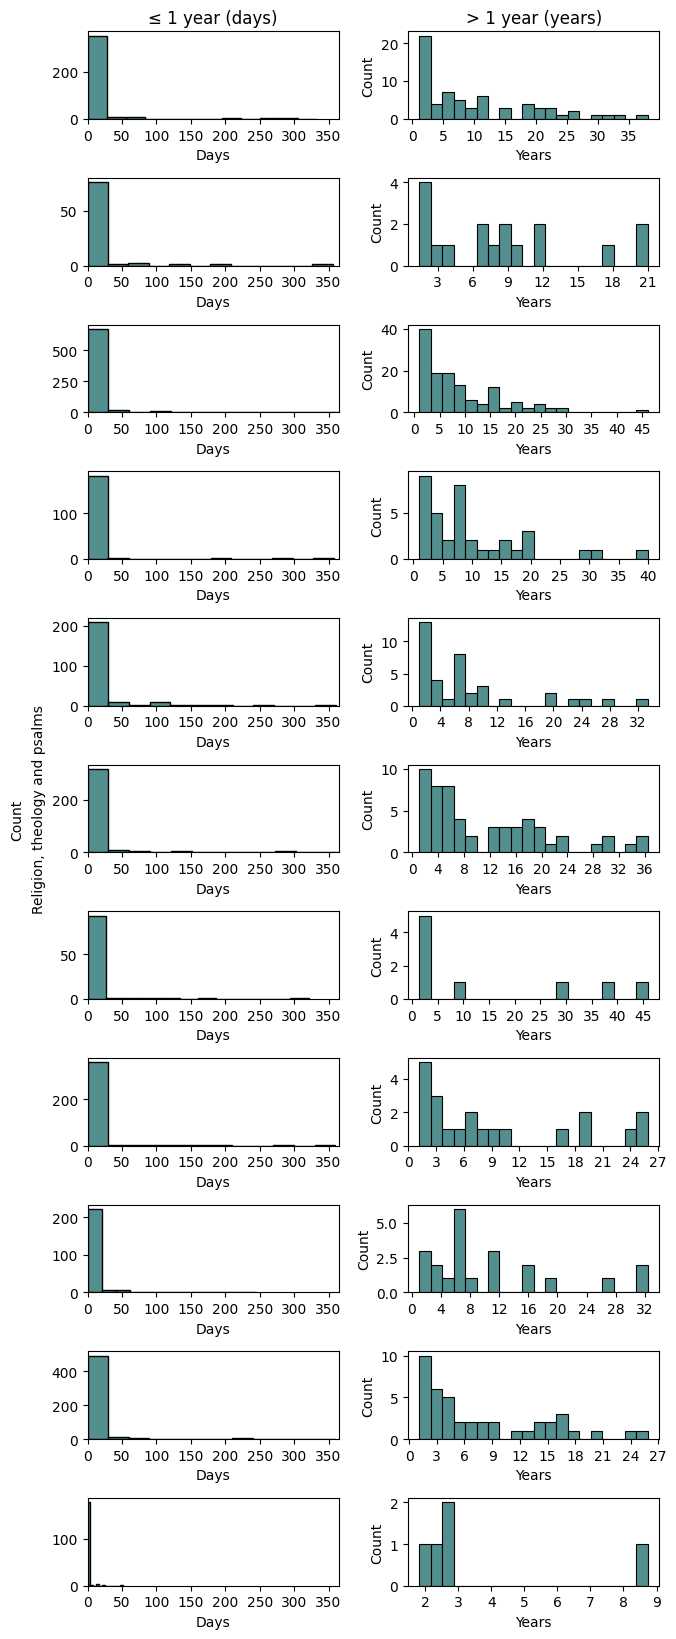

In [123]:
# Prepare data
book_stats_all = book_stats.copy()
book_stats_all["lifespan_years"] = book_stats_all["lifespan"] / 365

# Assign period
book_stats_all["period"] = pd.cut(
    book_stats_all["lifespan_years"],
    bins=[-0.1, 1, book_stats_all["lifespan_years"].max()],
    labels=["≤ 1 year (days)", "> 1 year (years)"],
    include_lowest=True,
    right=True
)

# Two different x-variables depending on period
book_stats_all["x_days"] = book_stats_all["lifespan"]
book_stats_all["x_years"] = book_stats_all["lifespan_years"]

# Sort categories by median lifespan (nonzero)
order = (
    book_stats_all[book_stats_all["lifespan"] > 0]
    .groupby("category")["lifespan_years"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Create subplot grid: n rows, 2 columns
n_cat = len(order)
fig, axes = plt.subplots(n_cat, 2, figsize=(7, 1.5 * n_cat), sharey=False)

if n_cat == 1:
    axes = [axes]  # ensure iterable if only 1 category

for i, cat in enumerate(order):
    # Subset data
    data_cat = book_stats_all[book_stats_all["category"] == cat]

    # --- Left subplot: ≤ 1 year (days) ---
    ax_left = axes[i][0]
    sns.histplot(
        data=data_cat[data_cat["period"] == "≤ 1 year (days)"],
        x="x_days",
        bins=12,
        color="#297373",
        alpha=0.8,
        ax=ax_left
    )
    ax_left.set_xlim(0, 365)
    ax_left.set_xlabel("Days")
    ax_left.set_ylabel(cat if i == n_cat // 2 else "")  # label only middle row
    ax_left.set_title("≤ 1 year (days)" if i == 0 else "")
    ax_left.xaxis.set_major_locator(mticker.MultipleLocator(50))

    # --- Right subplot: > 1 year (years) ---
    ax_right = axes[i][1]
    sns.histplot(
        data=data_cat[data_cat["period"] == "> 1 year (years)"],
        x="x_years",
        bins=20,
        color="#297373",
        alpha=0.8,
        ax=ax_right
    )
    ax_right.set_xlabel("Years")
    ax_right.set_title("> 1 year (years)" if i == 0 else "")
    ax_right.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Common y-label
fig.text(0.04, 0.5, "Count", va="center", rotation="vertical")

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()

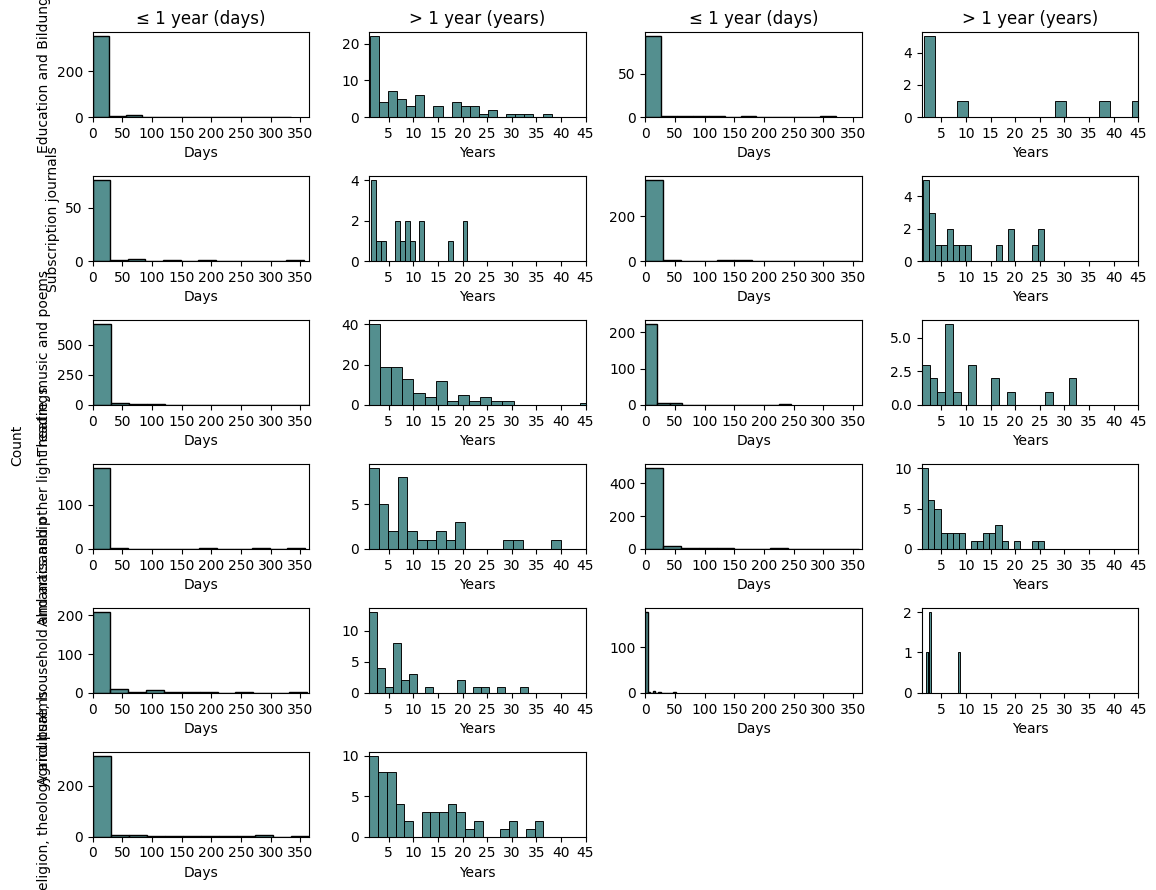

In [131]:
# Get a list of colors from the 'Paired' palette
custom_palette = [
    '#C2B748', '#E9D758', '#FAF2BA', #'#F2E480', #'#FAF2BA',  # yellows
    '#1E5252', '#297373', '#4FA5A5', '#B3DCDC',  # teals
    '#CC6942', '#FF8552', '#FFAA84', '#FFE1D6'   # corals
]

# Prepare data
book_stats_all = book_stats.copy()
book_stats_all["lifespan_years"] = book_stats_all["lifespan"] / 365

# Assign period
book_stats_all["period"] = pd.cut(
    book_stats_all["lifespan_years"],
    bins=[-0.1, 1, book_stats_all["lifespan_years"].max()],
    labels=["≤ 1 year (days)", "> 1 year (years)"],
    include_lowest=True,
    right=True
)

# Two different x-variables
book_stats_all["x_days"] = book_stats_all["lifespan"]
book_stats_all["x_years"] = book_stats_all["lifespan_years"]

# Sort categories
order = (
    book_stats_all[book_stats_all["lifespan"] > 0]
    .groupby("category")["lifespan_years"]
    .median()
    .sort_values(ascending=False)
    .index
)

n_cat = len(order)

# Split categories into two halves
mid = math.ceil(n_cat / 2)
left_cats = order[:mid]
right_cats = order[mid:]

# Create subplot grid: n_rows × 4 cols
n_rows = max(len(left_cats), len(right_cats))
fig, axes = plt.subplots(n_rows, 4, figsize=(12, 1.5 * n_rows), sharey=False)

# Function to plot one pair (days + years)
def plot_pair(ax_days, ax_years, data_cat, cat, show_ylabel):
    # Days
    sns.histplot(
        data=data_cat[data_cat["period"] == "≤ 1 year (days)"],
        x="x_days", bins=12, color="#297373", alpha=0.8, ax=ax_days
    )
    ax_days.set_xlim(0, 365)
    ax_days.set_xlabel("Days")
    ax_days.set_ylabel(cat if show_ylabel else "")
    ax_days.xaxis.set_major_locator(mticker.MultipleLocator(50))
    # Years
    sns.histplot(
        data=data_cat[data_cat["period"] == "> 1 year (years)"],
        x="x_years", bins=20, color="#297373", alpha=0.8, ax=ax_years
    )
    ax_years.set_xlim(1,45)
    ax_years.set_xlabel("Years")
    ax_years.set_ylabel("")
    ax_years.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Fill left block (columns 0–1)
for i, cat in enumerate(left_cats):
    data_cat = book_stats_all[book_stats_all["category"] == cat]
    plot_pair(axes[i, 0], axes[i, 1], data_cat, cat, show_ylabel=True)

# Fill right block (columns 2–3)
for i, cat in enumerate(right_cats):
    data_cat = book_stats_all[book_stats_all["category"] == cat]
    plot_pair(axes[i, 2], axes[i, 3], data_cat, cat, show_ylabel=False)

# Titles (only top row)
axes[0, 0].set_title("≤ 1 year (days)")
axes[0, 1].set_title("> 1 year (years)")
axes[0, 2].set_title("≤ 1 year (days)")
axes[0, 3].set_title("> 1 year (years)")

# Remove unused axes in the last row (right block)
if len(right_cats) < n_rows:
    axes[-1, 2].remove()
    axes[-1, 3].remove()

# Common y-label
fig.text(0.04, 0.5, "Count", va="center", rotation="vertical")

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()


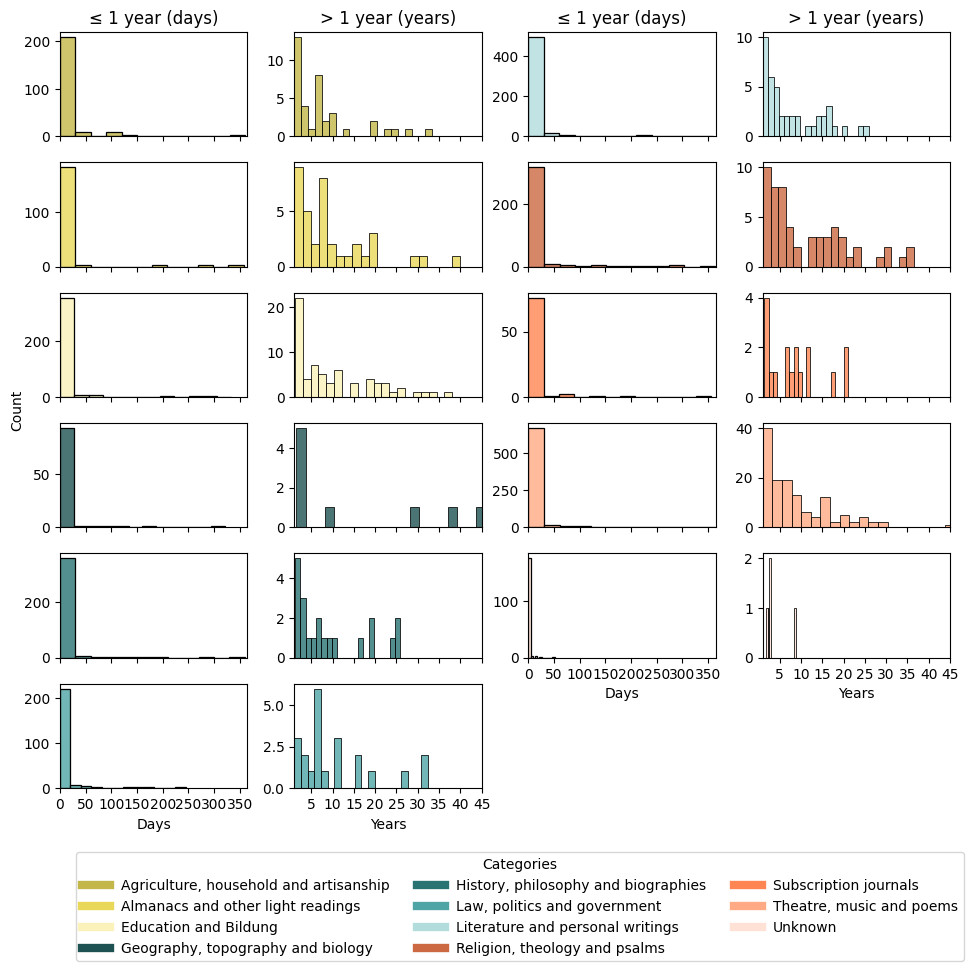

In [162]:
# Custom color palette
custom_palette = [
    '#C2B748', '#E9D758', '#FAF2BA',       # yellows
    '#1E5252', '#297373', '#4FA5A5', '#B3DCDC',  # teals
    '#CC6942', '#FF8552', '#FFAA84', '#FFE1D6'   # corals
]

# Prepare data
book_stats_all = book_stats.copy()
book_stats_all["lifespan_years"] = book_stats_all["lifespan"] / 365

# Assign period
book_stats_all["period"] = pd.cut(
    book_stats_all["lifespan_years"],
    bins=[-0.1, 1, book_stats_all["lifespan_years"].max()],
    labels=["≤ 1 year (days)", "> 1 year (years)"],
    include_lowest=True,
    right=True
)

# Two different x-variables
book_stats_all["x_days"] = book_stats_all["lifespan"]
book_stats_all["x_years"] = book_stats_all["lifespan_years"]

# Categories (order for coloring = alphabetical)
categories_sorted = sorted(book_stats_all["category"].unique())
color_map = {cat: custom_palette[i % len(custom_palette)]
             for i, cat in enumerate(categories_sorted)}

# Order for rows = by median lifespan
order = (
    book_stats_all[book_stats_all["lifespan"] > 0]
    .groupby("category")["lifespan_years"]
    .median()
    .sort_values(ascending=False)
    .index
)

order = categories_sorted

n_cat = len(order)

# Split categories into two halves
mid = math.ceil(n_cat / 2)
left_cats = order[:mid]
right_cats = order[mid:]

# Create subplot grid: n_rows × 4 cols
n_rows = max(len(left_cats), len(right_cats))
fig, axes = plt.subplots(n_rows, 4, figsize=(10, 1.5 * n_rows), sharey=False)

# Function to plot one pair (days + years)
def plot_pair(ax_days, ax_years, data_cat, cat, color):
    # Days
    sns.histplot(
        data=data_cat[data_cat["period"] == "≤ 1 year (days)"],
        x="x_days", bins=12, color=color, alpha=0.8, ax=ax_days
    )
    ax_days.set_xlim(0, 365)
    ax_days.set_xlabel("Days")
    ax_days.set_ylabel("")  # no category label
    ax_days.xaxis.set_major_locator(mticker.MultipleLocator(50))

    # Years
    sns.histplot(
        data=data_cat[data_cat["period"] == "> 1 year (years)"],
        x="x_years", bins=20, color=color, alpha=0.8, ax=ax_years
    )
    ax_years.set_xlim(1, 45)
    ax_years.set_xlabel("Years")
    ax_years.set_ylabel("")  # no category label
    ax_years.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Fill left block (columns 0–1)
for i, cat in enumerate(left_cats):
    data_cat = book_stats_all[book_stats_all["category"] == cat]
    plot_pair(axes[i, 0], axes[i, 1], data_cat, cat, color_map[cat])

# Fill right block (columns 2–3)
for i, cat in enumerate(right_cats):
    data_cat = book_stats_all[book_stats_all["category"] == cat]
    plot_pair(axes[i, 2], axes[i, 3], data_cat, cat, color_map[cat])

# Titles (only top row)
axes[0, 0].set_title("≤ 1 year (days)")
axes[0, 1].set_title("> 1 year (years)")
axes[0, 2].set_title("≤ 1 year (days)")
axes[0, 3].set_title("> 1 year (years)")

# Remove unused axes in the last row (right block)
if len(right_cats) < n_rows:
    axes[-1, 2].remove()
    axes[-1, 3].remove()

# Common y-label
fig.text(0.04, 0.5, "Count", va="center", rotation="vertical")

# Hide all x labels by default
for col in range(axes.shape[1]):
    for row in range(n_rows):
        axes[row, col].set_xlabel("")
        axes[row, col].tick_params(labelbottom=False)

# Add x labels only where needed
# Left block (cols 0–1): bottom row
for col in [0, 1]:
    axes[-1, col].set_xlabel("Days" if col % 2 == 0 else "Years")
    axes[-1, col].tick_params(labelbottom=True)

# Right block (cols 2–3): second-to-last row (since last is legend/empty)
for col in [2, 3]:
    axes[-2, col].set_xlabel("Days" if col % 2 == 0 else "Years")
    axes[-2, col].tick_params(labelbottom=True)

# Legend
handles = [plt.Line2D([0], [0], color=color_map[cat], lw=6)
           for cat in categories_sorted]
fig.legend(handles, categories_sorted,
           title="Categories", loc="lower center",
           ncol=3, bbox_to_anchor=(0.55, -0.12))

# Instead of plt.tight_layout(...)
plt.subplots_adjust(
    left=0.09,   # space for y-label
    right=0.98,  # space on the right
    top=0.92,    # leave room for titles
    bottom=0.08, # leave room for x-labels
    hspace=0.25, # vertical spacing between rows
    wspace=0.25  # horizontal spacing between columns
)

#plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.savefig('../figures/histo_ad_span_books.pdf', bbox_inches='tight')
plt.show()


In [167]:
zero_share

category
Agriculture, household and artisanship    69.5
Almanacs and other light readings         69.3
Education and Bildung                     72.5
Geography, topography and biology         75.9
History, philosophy and biographies       82.7
Law, politics and government              75.9
Literature and personal writings          76.6
Religion, theology and psalms             66.4
Subscription journals                     66.7
Theatre, music and poems                  70.4
Unknown                                   93.1
Name: lifespan, dtype: float64

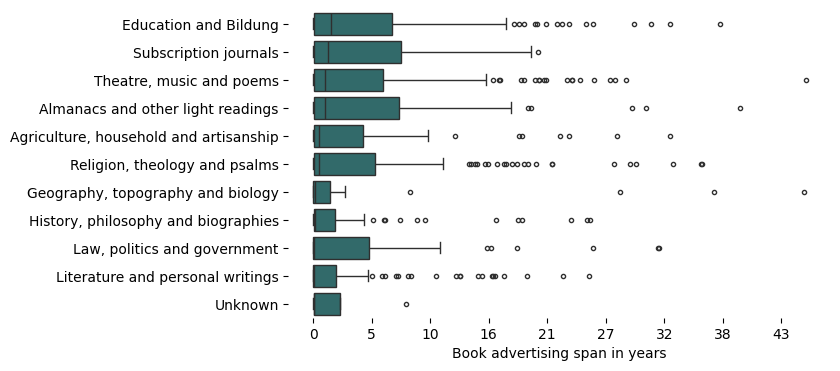

In [166]:
# Boxplots

# Exclude zero-day lifespans
book_stats_nonzero = book_stats[book_stats['lifespan'] > 0]

# Sort categories by name or by median lifespan if you prefer
order = (
    book_stats_nonzero.groupby('category')['lifespan']
    .median()
    .sort_values(ascending=False)
    .index
)

# Average ads per book per category
avg_ads = (
    book_stats_nonzero.groupby("category")["count"]
    .mean()
    .round(1)
)

# Share of 0-day lifespans per category
zero_share = (
    book_stats.groupby("category")["lifespan"]
    .apply(lambda x: (x == 0).mean() * 100)
    .round(1)
)

# --- Plot ---
plt.figure(figsize=(7, 4))
sns.boxplot(
    data=book_stats_nonzero,
    y="category",       # categories stacked vertically
    x="lifespan",       # lifespan on horizontal axis
    order=order,        # order categories by median lifespan
    #showfliers=False,
    orient="h",
    color="#297373",    # same color as before
    fliersize=3,        # show outliers
    linewidth=1
)

plt.xlabel("Book advertising span in years")
plt.ylabel("")  # category names on y-axis
#plt.title("Distribution of Book Lifespans per Category") # Books with 1 ad are excluded here - re-advertised books only

# Convert x axis ticks from days → years
ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/365)}"))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

sns.despine(left=True, bottom=True)
#plt.tight_layout()
plt.savefig('../figures/boxplot_lifespan_books.pdf', bbox_inches='tight')
plt.show()

#### Per author

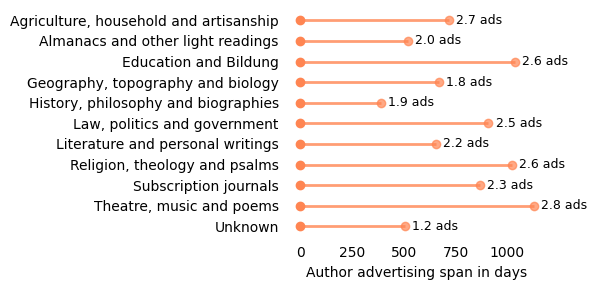

In [41]:
# Group by title and category
df_no_author = df[df['author'] != 'NO_AUTHOR']
grouped_authors = df_no_author.groupby(['author', 'category'])

# Calculate lifespan and ad count per book
author_stats = grouped_authors['date'].agg(['min', 'max', 'count']).reset_index()
author_stats['lifespan'] = (author_stats['max'] - author_stats['min']).dt.days + 1 

# Average per category
category_stats = author_stats.groupby('category').agg(
    avg_lifespan=('lifespan', 'mean'),
    avg_ads=('count', 'mean')
).reset_index()

# Sort categories for clear plot
category_stats = category_stats.sort_values(by='category', ascending=False).reset_index(drop=True)

# Plot
fig, ax = plt.subplots(figsize=(6, 3))

for i, row in category_stats.iterrows():
    y = i
    ax.hlines(y, 0, row['avg_lifespan'], color='#FF8552', linewidth=2, linestyles='solid', alpha=0.8)
    ax.plot(0, y, 'o', color='#FF8552')  # Start at 0
    ax.plot(row['avg_lifespan'], y, 'o', color='#FF8552', alpha=0.7)  # End at lifespan
    ax.text(row['avg_lifespan'] + 15, y, f" {row['avg_ads']:.1f} ads", va='center', fontsize=9)

# Labels and formatting
ax.set_yticks(range(len(category_stats)))
ax.set_yticklabels(category_stats['category'])
ax.set_xlabel("Author advertising span in days")
#ax.set_title("Average Book Lifespan per Category\n(Green = first appearance, Red = last)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False)
ax.tick_params(bottom=False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
#plt.savefig('../figures/lifespan_authors.pdf', bbox_inches='tight')
plt.show()

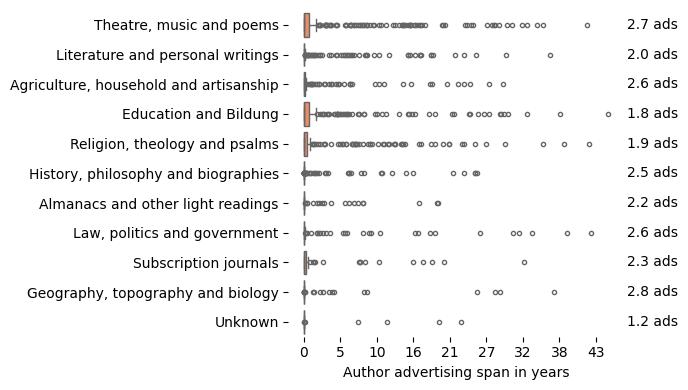

In [52]:
# Boxplot

# Exclude zero-day lifespans
author_stats_nonzero = author_stats[author_stats['lifespan'] > 0]

# Sort categories by name or by median lifespan if you prefer
order = (
    author_stats_nonzero.groupby('category')['lifespan']
    .median()
    .sort_values(ascending=False)
    .index
)

# Average ads per book per category
avg_ads = (
    author_stats_nonzero.groupby("category")["count"]
    .mean()
    .round(1)
)

# --- Plot ---
plt.figure(figsize=(7, 4))
sns.boxplot(
    data=author_stats_nonzero,
    y="category",       # categories stacked vertically
    x="lifespan",       # lifespan on horizontal axis
    #order=order,        # order categories by median lifespan
    #showfliers=False,
    orient="h",
    color='#FF8552',    # same color as before
    fliersize=3,        # show outliers
    linewidth=1
)

plt.xlabel("Author advertising span in years")
plt.ylabel("")  # category names on y-axis
#plt.title("Distribution of Book Lifespans per Category") # Books with 1 ad are excluded here - re-advertised books only

# Convert x axis ticks from days → years
ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/365)}"))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# --- Add avg ads per category as text labels ---
for i, cat in enumerate(order):
    ax.text(
        x=ax.get_xlim()[1] * 1.01,  # place a bit beyond the max x-axis
        y=i,
        s=f"{avg_ads[cat]} ads",
        va="center",
        fontsize=10,
        color="black"
    )

sns.despine(left=True, bottom=True)
plt.tight_layout()
#plt.savefig('../figures/boxplot_lifespan_authors.pdf', bbox_inches='tight')
plt.show()

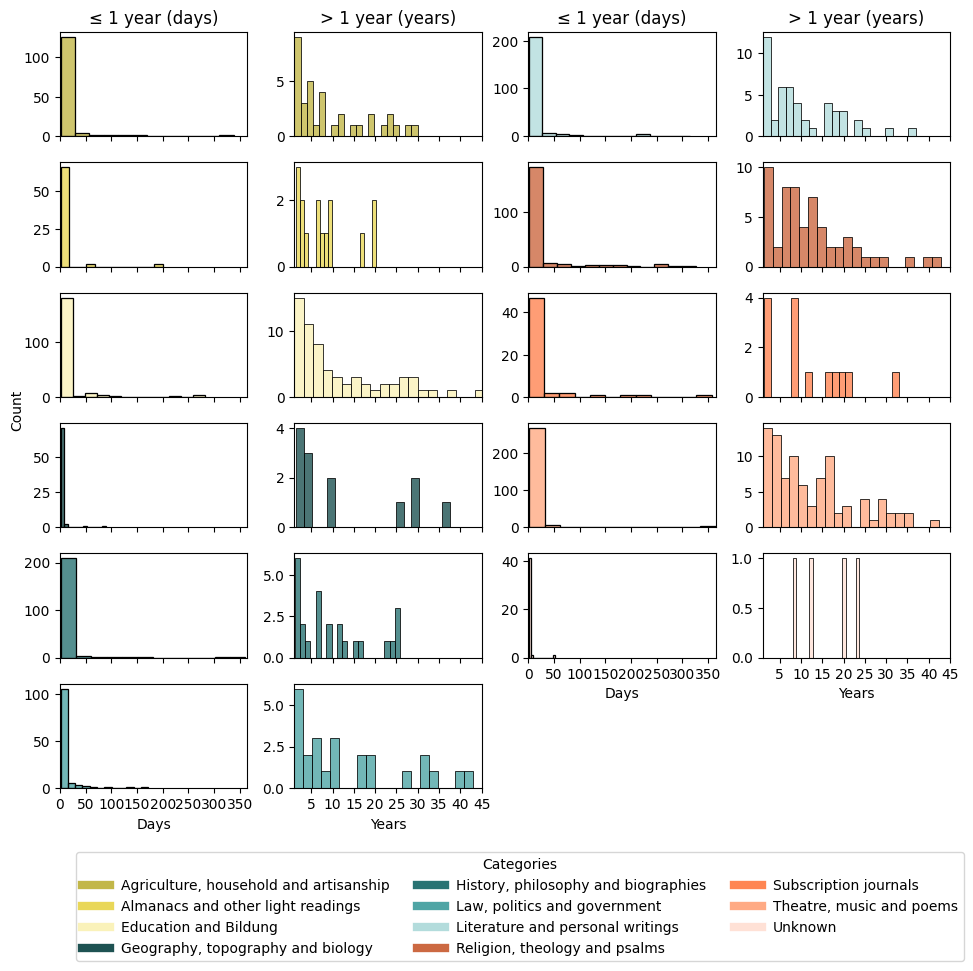

In [163]:
# Prepare data
author_stats_all = author_stats.copy()
author_stats_all["lifespan_years"] = author_stats_all["lifespan"] / 365

# Assign period
author_stats_all["period"] = pd.cut(
    author_stats_all["lifespan_years"],
    bins=[-0.1, 1, author_stats_all["lifespan_years"].max()],
    labels=["≤ 1 year (days)", "> 1 year (years)"],
    include_lowest=True,
    right=True
)

# Two different x-variables
author_stats_all["x_days"] = author_stats_all["lifespan"]
author_stats_all["x_years"] = author_stats_all["lifespan_years"]

# Categories (order for coloring = alphabetical)
categories_sorted = sorted(author_stats_all["category"].unique())
color_map = {cat: custom_palette[i % len(custom_palette)]
             for i, cat in enumerate(categories_sorted)}

# Order for rows = by median lifespan
order = (
    author_stats_all[author_stats_all["lifespan"] > 0]
    .groupby("category")["lifespan_years"]
    .median()
    .sort_values(ascending=False)
    .index
)

order = categories_sorted

n_cat = len(order)

# Split categories into two halves
mid = math.ceil(n_cat / 2)
left_cats = order[:mid]
right_cats = order[mid:]

# Create subplot grid: n_rows × 4 cols
n_rows = max(len(left_cats), len(right_cats))
fig, axes = plt.subplots(n_rows, 4, figsize=(10, 1.5 * n_rows), sharey=False)

# Function to plot one pair (days + years)
def plot_pair(ax_days, ax_years, data_cat, cat, color):
    # Days
    sns.histplot(
        data=data_cat[data_cat["period"] == "≤ 1 year (days)"],
        x="x_days", bins=12, color=color, alpha=0.8, ax=ax_days
    )
    ax_days.set_xlim(0, 365)
    ax_days.set_xlabel("Days")
    ax_days.set_ylabel("")  # no category label
    ax_days.xaxis.set_major_locator(mticker.MultipleLocator(50))

    # Years
    sns.histplot(
        data=data_cat[data_cat["period"] == "> 1 year (years)"],
        x="x_years", bins=20, color=color, alpha=0.8, ax=ax_years
    )
    ax_years.set_xlim(1, 45)
    ax_years.set_xlabel("Years")
    ax_years.set_ylabel("")  # no category label
    ax_years.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Fill left block (columns 0–1)
for i, cat in enumerate(left_cats):
    data_cat = author_stats_all[author_stats_all["category"] == cat]
    plot_pair(axes[i, 0], axes[i, 1], data_cat, cat, color_map[cat])

# Fill right block (columns 2–3)
for i, cat in enumerate(right_cats):
    data_cat = author_stats_all[author_stats_all["category"] == cat]
    plot_pair(axes[i, 2], axes[i, 3], data_cat, cat, color_map[cat])

# Titles (only top row)
axes[0, 0].set_title("≤ 1 year (days)")
axes[0, 1].set_title("> 1 year (years)")
axes[0, 2].set_title("≤ 1 year (days)")
axes[0, 3].set_title("> 1 year (years)")

# Remove unused axes in the last row (right block)
if len(right_cats) < n_rows:
    axes[-1, 2].remove()
    axes[-1, 3].remove()

# Common y-label
fig.text(0.04, 0.5, "Count", va="center", rotation="vertical")

# Hide all x labels by default
for col in range(axes.shape[1]):
    for row in range(n_rows):
        axes[row, col].set_xlabel("")
        axes[row, col].tick_params(labelbottom=False)

# Add x labels only where needed
# Left block (cols 0–1): bottom row
for col in [0, 1]:
    axes[-1, col].set_xlabel("Days" if col % 2 == 0 else "Years")
    axes[-1, col].tick_params(labelbottom=True)

# Right block (cols 2–3): second-to-last row (since last is legend/empty)
for col in [2, 3]:
    axes[-2, col].set_xlabel("Days" if col % 2 == 0 else "Years")
    axes[-2, col].tick_params(labelbottom=True)

# Legend
handles = [plt.Line2D([0], [0], color=color_map[cat], lw=6)
           for cat in categories_sorted]
fig.legend(handles, categories_sorted,
           title="Categories", loc="lower center",
           ncol=3, bbox_to_anchor=(0.55, -0.12))

# Instead of plt.tight_layout(...)
plt.subplots_adjust(
    left=0.09,   # space for y-label
    right=0.98,  # space on the right
    top=0.92,    # leave room for titles
    bottom=0.08, # leave room for x-labels
    hspace=0.25, # vertical spacing between rows
    wspace=0.25  # horizontal spacing between columns
)

#plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.savefig('../figures/histo_ad_span_authors.pdf', bbox_inches='tight')
plt.show()

### Modeling, second attempt

In [5]:
# Make sure 'year' is a separate column (if not already)
df['year'] = pd.to_datetime(df['date']).dt.year

# Group and count
counts = df.groupby(['newspaper', 'year', 'category']).size().reset_index(name='count')

In [6]:
nsp_counts = pd.read_csv('../data/nsp_counts.csv', index_col=0)
nsp_counts

,newspaper,year,count_nsp
0,aal,1818,150
1,aal,1819,158
2,aal,1820,152
3,aal,1821,163
4,aal,1822,163
...,...,...,...
200,vib,1838,164
201,vib,1839,189
202,vib,1840,209
203,vib,1841,210


In [123]:
counts

,newspaper,year,category,count
0,aal,1818,Almanacs and other light readings,2
1,aal,1818,Education and Bildung,8
2,aal,1818,"Geography, topography and biology",2
3,aal,1818,"History, philosophy and biographies",4
4,aal,1818,"Law, politics and government",3
...,...,...,...,...
1529,vib,1842,Literature and personal writings,11
1530,vib,1842,"Religion, theology and psalms",3
1531,vib,1842,Subscription journals,4
1532,vib,1842,"Theatre, music and poems",14


#### Compute normalized counts of book titles in category per newspaper per year

In [7]:
# Step 3: Merge on 'newspaper' and 'year'
merged = counts.merge(nsp_counts, on=['newspaper', 'year'], how='left')

# Step 4: Normalize the counts
merged['normalized_count'] = merged['count'] / merged['count_nsp']

merged

,newspaper,year,category,count,count_nsp,normalized_count
0,aal,1818,Almanacs and other light readings,2,150,0.013333
1,aal,1818,Education and Bildung,8,150,0.053333
2,aal,1818,"Geography, topography and biology",2,150,0.013333
3,aal,1818,"History, philosophy and biographies",4,150,0.026667
4,aal,1818,"Law, politics and government",3,150,0.020000
...,...,...,...,...,...,...
1529,vib,1842,Literature and personal writings,11,205,0.053659
1530,vib,1842,"Religion, theology and psalms",3,205,0.014634
1531,vib,1842,Subscription journals,4,205,0.019512
1532,vib,1842,"Theatre, music and poems",14,205,0.068293


In [70]:
# cities

cities = pd.read_csv('../data/cities.csv')
cities

,nsp,City,Population,Accessibility
0,aal,Aalborg,6500,102
1,aar,Aarhus,6000,78
2,lol,Maribo,1000,30
3,ode,Odense,8000,33
4,thi,Thisted,1600,109
5,vib,Viborg,3100,85


In [72]:
# Linear regression

# X = (population)
# y = number of titles in a city

total_titles = merged.groupby('newspaper')['normalized_count'].sum().reset_index(name='total_titles')

In [77]:
merged

,newspaper,year,category,count,count_nsp,normalized_count
0,aal,1818,Almanacs and other light readings,2,150,0.013333
1,aal,1818,Education and Bildung,8,150,0.053333
2,aal,1818,"Geography, topography and biology",2,150,0.013333
3,aal,1818,"History, philosophy and biographies",4,150,0.026667
4,aal,1818,"Law, politics and government",3,150,0.020000
...,...,...,...,...,...,...
1529,vib,1842,Literature and personal writings,11,205,0.053659
1530,vib,1842,"Religion, theology and psalms",3,205,0.014634
1531,vib,1842,Subscription journals,4,205,0.019512
1532,vib,1842,"Theatre, music and poems",14,205,0.068293


In [79]:
merged_cities = merged.merge(cities, left_on='newspaper', right_on='nsp')
merged_cities

,newspaper,year,category,count,count_nsp,normalized_count,nsp,City,Population,Accessibility
0,aal,1818,Almanacs and other light readings,2,150,0.013333,aal,Aalborg,6500,102
1,aal,1818,Education and Bildung,8,150,0.053333,aal,Aalborg,6500,102
2,aal,1818,"Geography, topography and biology",2,150,0.013333,aal,Aalborg,6500,102
3,aal,1818,"History, philosophy and biographies",4,150,0.026667,aal,Aalborg,6500,102
4,aal,1818,"Law, politics and government",3,150,0.020000,aal,Aalborg,6500,102
...,...,...,...,...,...,...,...,...,...,...
1529,vib,1842,Literature and personal writings,11,205,0.053659,vib,Viborg,3100,85
1530,vib,1842,"Religion, theology and psalms",3,205,0.014634,vib,Viborg,3100,85
1531,vib,1842,Subscription journals,4,205,0.019512,vib,Viborg,3100,85
1532,vib,1842,"Theatre, music and poems",14,205,0.068293,vib,Viborg,3100,85


In [80]:
merged_cities['log_population'] = np.log(merged_cities['Population'])

In [110]:
# Step 1: Group by newspaper and year to get total count per group
merged_cities['total_in_year_newspaper'] = merged_cities.groupby(['newspaper', 'year'])['count'].transform('sum')

# Step 2: Normalize count by total to get relative count
merged_cities['relative_count'] = merged_cities['count'] / merged_cities['total_in_year_newspaper']

In [97]:
education = merged_cities[merged_cities['category'] == 'Education and Bildung']
education

,newspaper,year,category,count,count_nsp,normalized_count,nsp,City,Population,Accessibility,log_population
1,aal,1818,Education and Bildung,8,150,0.053333,aal,Aalborg,6500,102,8.779557
11,aal,1819,Education and Bildung,3,158,0.018987,aal,Aalborg,6500,102,8.779557
20,aal,1820,Education and Bildung,12,152,0.078947,aal,Aalborg,6500,102,8.779557
28,aal,1821,Education and Bildung,7,163,0.042945,aal,Aalborg,6500,102,8.779557
39,aal,1822,Education and Bildung,4,163,0.024540,aal,Aalborg,6500,102,8.779557
...,...,...,...,...,...,...,...,...,...,...,...
1469,vib,1833,Education and Bildung,6,155,0.038710,vib,Viborg,3100,85,8.039157
1483,vib,1835,Education and Bildung,2,157,0.012739,vib,Viborg,3100,85,8.039157
1498,vib,1838,Education and Bildung,2,164,0.012195,vib,Viborg,3100,85,8.039157
1505,vib,1839,Education and Bildung,4,189,0.021164,vib,Viborg,3100,85,8.039157


In [74]:
mean_population = cities['Population'].mean()

#### Number of book advertisements dependent on population and accessiblility

In [82]:
import statsmodels.formula.api as smf

In [ ]:
# CORRECT MODEL: HYPOTHESIS REJECTED. SUPER SMALL EFFECT SMALLER, VILLAGES CAN HAVE MORE BOOK ANNOUNCEMENTS

# Model: number of titles ~ log(population) + (1 | year)
model = smf.mixedlm("normalized_count ~ log_population", merged_cities, groups=merged_cities["year"])
result = model.fit()

print(result.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: normalized_count
No. Observations: 1534    Method:             REML            
No. Groups:       55      Scale:              0.0014          
Min. group size:  4       Log-Likelihood:     2845.4357       
Max. group size:  56      Converged:          Yes             
Mean group size:  27.9                                        
---------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept        0.139     0.011  12.262  0.000   0.117   0.161
log_population  -0.013     0.001  -9.912  0.000  -0.016  -0.011
Group Var        0.000     0.001                               



/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


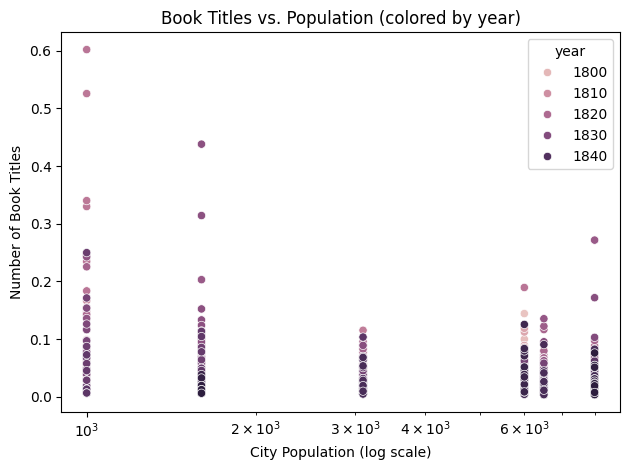

In [95]:
sns.scatterplot(data=merged_cities, x='Population', y='normalized_count', hue='year')
plt.xscale('log')
plt.xlabel('City Population (log scale)')
plt.ylabel('Number of Book Titles')
plt.title('Book Titles vs. Population (colored by year)')
plt.tight_layout()
plt.show()

In [ ]:
# EDUCATION AND BILDUNG: MORE IN SMALLER TOWNS

# Model: number of education titles ~ log(population) + (1 | year)
model = smf.mixedlm("normalized_count ~ log_population + Accessibility", education, groups=education["year"])
result = model.fit()

print(result.summary()) 

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: normalized_count
No. Observations: 173     Method:             REML            
No. Groups:       51      Scale:              0.0028          
Min. group size:  1       Log-Likelihood:     241.6256        
Max. group size:  6       Converged:          Yes             
Mean group size:  3.4                                         
---------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept        0.259     0.047   5.462  0.000   0.166   0.352
log_population  -0.026     0.006  -4.618  0.000  -0.036  -0.015
Accessibility   -0.000     0.000  -1.205  0.228  -0.000   0.000
Group Var        0.000     0.006                               



/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


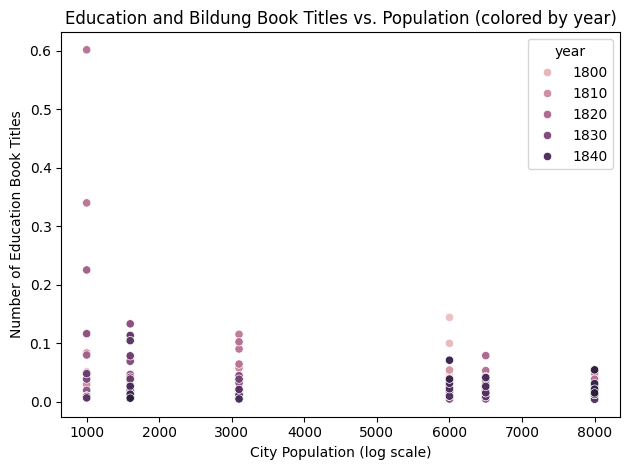

In [102]:
sns.scatterplot(data=education, x='Population', y='normalized_count', hue='year')
#plt.xscale('log')
plt.xlabel('City Population (log scale)')
plt.ylabel('Number of Education Book Titles')
plt.title('Education and Bildung Book Titles vs. Population (colored by year)')
plt.tight_layout()
plt.show()

In [112]:
# RELIGION IN VIBORG

religion = merged_cities[merged_cities['category'] == 'Religion, theology and psalms']
religion['is_viborg'] = (religion['newspaper'] == 'vib').astype(int)

# Mixed effects model: fixed effect for is_viborg, random intercept for year
model = smf.mixedlm("relative_count ~ is_viborg", data=religion, groups=religion["year"])
result = model.fit()

print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: relative_count
No. Observations: 165     Method:             REML          
No. Groups:       54      Scale:              0.0100        
Min. group size:  1       Log-Likelihood:     135.9004      
Max. group size:  6       Converged:          Yes           
Mean group size:  3.1                                       
-------------------------------------------------------------
               Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.156     0.010  16.357  0.000   0.137   0.175
is_viborg      0.026     0.020   1.286  0.198  -0.013   0.064
Group Var      0.000     0.009                               



/var/folders/dt/1462j2zd19q_2sh2_66j7_8m6l1brz/T/ipykernel_8169/2078480533.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  religion['is_viborg'] = (religion['newspaper'] == 'vib').astype(int)
/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [124]:
merged_cities

,newspaper,year,category,count,count_nsp,normalized_count,nsp,City,Population,Accessibility,log_population,total_in_year_newspaper,relative_count
0,aal,1818,Almanacs and other light readings,2,150,0.013333,aal,Aalborg,6500,102,8.779557,36,0.055556
1,aal,1818,Education and Bildung,8,150,0.053333,aal,Aalborg,6500,102,8.779557,36,0.222222
2,aal,1818,"Geography, topography and biology",2,150,0.013333,aal,Aalborg,6500,102,8.779557,36,0.055556
3,aal,1818,"History, philosophy and biographies",4,150,0.026667,aal,Aalborg,6500,102,8.779557,36,0.111111
4,aal,1818,"Law, politics and government",3,150,0.020000,aal,Aalborg,6500,102,8.779557,36,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,vib,1842,Literature and personal writings,11,205,0.053659,vib,Viborg,3100,85,8.039157,44,0.250000
1530,vib,1842,"Religion, theology and psalms",3,205,0.014634,vib,Viborg,3100,85,8.039157,44,0.068182
1531,vib,1842,Subscription journals,4,205,0.019512,vib,Viborg,3100,85,8.039157,44,0.090909
1532,vib,1842,"Theatre, music and poems",14,205,0.068293,vib,Viborg,3100,85,8.039157,44,0.318182


In [121]:
# RELIGION VERSUS THEATRE IN VIBORG

# Subset for just the two relevant categories
subset = merged_cities[
    merged_cities['category'].isin(['Religion, theology and psalms', 'Theatre, music and poems'])
].copy()

# Binary flags
subset['is_viborg'] = (subset['newspaper'] == 'vib').astype(int)
subset['is_religion'] = (subset['category'] == 'Religion, theology and psalms').astype(int)

# Interaction term
subset['interaction'] = subset['is_viborg'] * subset['is_religion']

# Mixed effects model with year as random intercept
import statsmodels.formula.api as smf
model = smf.mixedlm(
    "relative_count ~ is_viborg + is_religion + interaction",
    data=subset,
    groups=subset["year"]
)
result = model.fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: relative_count
No. Observations: 344     Method:             REML          
No. Groups:       55      Scale:              0.0196        
Min. group size:  1       Log-Likelihood:     177.7732      
Max. group size:  12      Converged:          Yes           
Mean group size:  6.3                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.250     0.011  21.973  0.000   0.227   0.272
is_viborg     -0.021     0.029  -0.728  0.466  -0.079   0.036
is_religion   -0.095     0.017  -5.690  0.000  -0.127  -0.062
interaction    0.046     0.040   1.150  0.250  -0.033   0.125
Group Var      0.000     0.008                               



/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [130]:
# count rel. vs count. theat.

# Step 2: Pivot the data so you have columns: 'Religion', 'Theatre'
pivot_df = subset.pivot_table(
    index=['newspaper', 'year'],
    columns='category',
    values='relative_count'
).reset_index()

# Optional: Rename columns for ease
pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={
    'Religion, theology and psalms': 'religion_share',
    'Theatre, music and poems': 'theatre_share'
})

# Step 3: Drop rows with missing data (in case a city-year is missing one category)
pivot_df = pivot_df.dropna(subset=['religion_share', 'theatre_share'])

model = smf.mixedlm("religion_share ~ theatre_share", data=pivot_df, groups=pivot_df["year"])
result = model.fit()

print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: religion_share
No. Observations: 143     Method:             REML          
No. Groups:       51      Scale:              0.0078        
Min. group size:  1       Log-Likelihood:     134.4619      
Max. group size:  6       Converged:          Yes           
Mean group size:  2.8                                       
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.188    0.015 12.849 0.000  0.159  0.216
theatre_share     -0.184    0.058 -3.185 0.001 -0.297 -0.071
Group Var          0.001    0.010                           



/Users/au711514/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [125]:
subset

,newspaper,year,category,count,count_nsp,normalized_count,nsp,City,Population,Accessibility,log_population,total_in_year_newspaper,relative_count,is_viborg,is_religion,interaction
6,aal,1818,"Religion, theology and psalms",12,150,0.080000,aal,Aalborg,6500,102,8.779557,36,0.333333,0,1,0
8,aal,1818,"Theatre, music and poems",2,150,0.013333,aal,Aalborg,6500,102,8.779557,36,0.055556,0,0,0
15,aal,1819,"Religion, theology and psalms",3,158,0.018987,aal,Aalborg,6500,102,8.779557,32,0.093750,0,1,0
16,aal,1819,"Theatre, music and poems",6,158,0.037975,aal,Aalborg,6500,102,8.779557,32,0.187500,0,0,0
23,aal,1820,"Religion, theology and psalms",6,152,0.039474,aal,Aalborg,6500,102,8.779557,52,0.115385,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,vib,1840,"Religion, theology and psalms",4,209,0.019139,vib,Viborg,3100,85,8.039157,19,0.210526,1,1,1
1521,vib,1841,"Religion, theology and psalms",2,210,0.009524,vib,Viborg,3100,85,8.039157,15,0.133333,1,1,1
1522,vib,1841,"Theatre, music and poems",2,210,0.009524,vib,Viborg,3100,85,8.039157,15,0.133333,1,0,0
1530,vib,1842,"Religion, theology and psalms",3,205,0.014634,vib,Viborg,3100,85,8.039157,44,0.068182,1,1,1


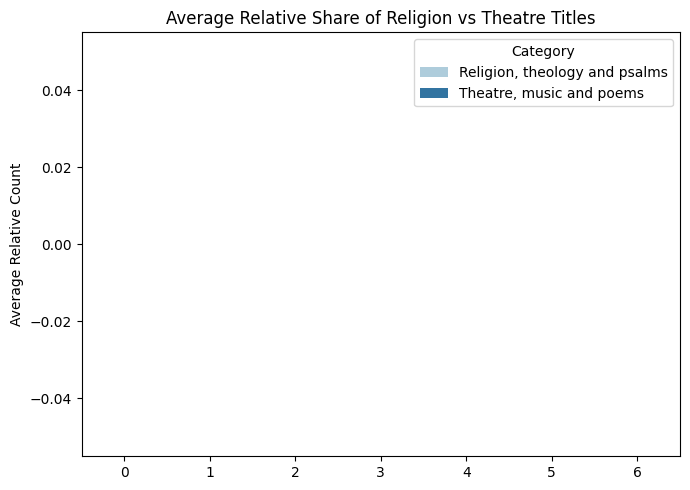

In [123]:
# Group by city and category to get average relative count
avg_relative = subset.groupby(['is_viborg', 'category'])['relative_count'].mean().reset_index()

# Rename for clarity
avg_relative['City'] = avg_relative['is_viborg'].map({True: 'Viborg', False: 'Other Towns'})

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(data=avg_relative, x='City', y='relative_count', hue='category', palette='Paired')
plt.title('Average Relative Share of Religion vs Theatre Titles')
plt.ylabel('Average Relative Count')
plt.xlabel('')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

In [9]:
counts_really_all = df.groupby(['newspaper', 'category']).size().reset_index(name='count')

In [10]:
category_shares = counts_really_all.copy()

# Group by newspaper and compute total per newspaper
category_shares['total_in_paper'] = category_shares.groupby('newspaper')['count'].transform('sum')

# Compute category share within each newspaper
category_shares['category_share'] = category_shares['count'] / category_shares['total_in_paper']

In [25]:
category_shares

,newspaper,category,count,total_in_paper,category_share
0,aal,"Agriculture, household and artisanship",69,965,0.071503
1,aal,Almanacs and other light readings,62,965,0.064249
2,aal,Education and Bildung,119,965,0.123316
3,aal,"Geography, topography and biology",25,965,0.025907
4,aal,"History, philosophy and biographies",90,965,0.093264
...,...,...,...,...,...
61,vib,Literature and personal writings,88,854,0.103044
62,vib,"Religion, theology and psalms",144,854,0.168618
63,vib,Subscription journals,21,854,0.024590
64,vib,"Theatre, music and poems",158,854,0.185012


In [11]:
custom_palette2 = [
     '#E9D758', '#FAF2BA', # yellows
     '#297373', '#4FA5A5', # teals
   '#FF8552', '#FFAA84' # corals
]

legend_labels = {'aal': 'Aalborg',
                 'aar': 'Aarhus',
                 'lol': 'Maribo',
                 'ode': 'Odense',
                 'thi': 'Thisted',
                 'vib': 'Viborg'}

# Map categories to colors
# Make sure each newspaper maps to a unique color
unique_newspapers = category_shares['newspaper'].unique()
newspaper_to_color = dict(zip(unique_newspapers, custom_palette2))

#### Make a PCA of the newspaper category distributions

In [12]:
# Step 1: Pivot so each newspaper is a row, and each column is a category_share
pivot_df = category_shares.pivot(index='newspaper', columns='category', values='category_share').fillna(0)

In [26]:
pivot_df_raw = category_shares.pivot(index='newspaper', columns='category', values='count').fillna(0)
pivot_df_raw

category,"Agriculture, household and artisanship",Almanacs and other light readings,Education and Bildung,"Geography, topography and biology","History, philosophy and biographies","Law, politics and government",Literature and personal writings,"Religion, theology and psalms",Subscription journals,"Theatre, music and poems",Unknown
newspaper,,,,,,,,,,,
aal,69,62,119,25,90,75,110,103,31,243,38
aar,131,90,152,45,99,86,154,136,37,331,52
lol,83,38,183,15,162,45,113,146,22,211,31
ode,136,165,158,39,142,135,221,205,73,250,44
thi,45,33,108,18,55,38,114,77,16,117,21
vib,97,43,120,41,61,61,88,144,21,158,20


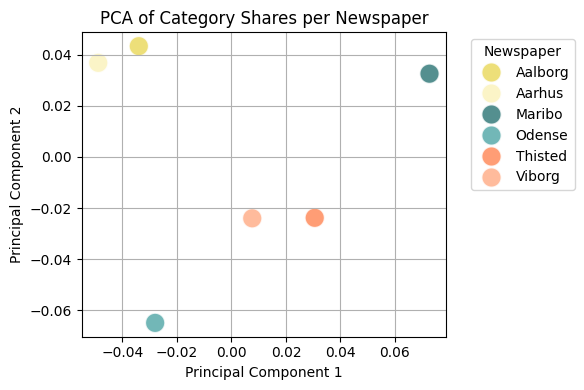

In [28]:
# Step 3: Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivot_df)

# Step 4: Plot
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=pivot_df.index)

plt.figure(figsize=(6, 4))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='newspaper', palette=newspaper_to_color, s=200, alpha=0.8)

# Annotate with newspaper names
#for index, row in pca_df.iterrows():
    #plt.text(row['PC1'], row['PC2'], index, fontsize=9)

plt.title('PCA of Category Shares per Newspaper')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Get original handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Replace labels with custom ones
custom_labels = [legend_labels[label] for label in labels]

# Apply updated legend
plt.legend(handles, custom_labels, title='Newspaper', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend([unique_newspapers])
plt.grid(True)
plt.tight_layout()
plt.show()

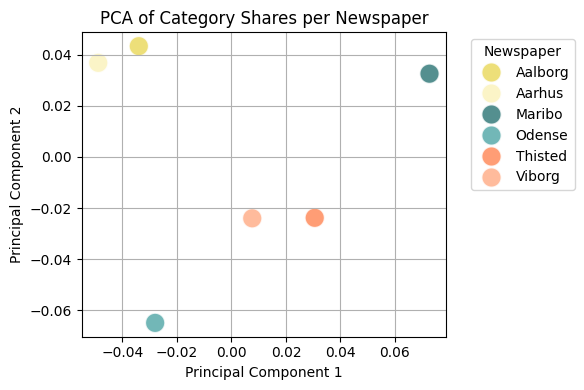

In [61]:
# Step 3: Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivot_df)

# Step 4: Plot
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=pivot_df_raw.index)

plt.figure(figsize=(6, 4))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='newspaper', palette=newspaper_to_color, s=200, alpha=0.8)

# Annotate with newspaper names
#for index, row in pca_df.iterrows():
    #plt.text(row['PC1'], row['PC2'], index, fontsize=9)

plt.title('PCA of Category Shares per Newspaper')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Get original handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Replace labels with custom ones
custom_labels = [legend_labels[label] for label in labels]

# Apply updated legend
plt.legend(handles, custom_labels, title='Newspaper', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend([unique_newspapers])
plt.grid(True)
plt.tight_layout()
plt.savefig('../figures/PCA_original.pdf', bbox_inches='tight')
plt.show()

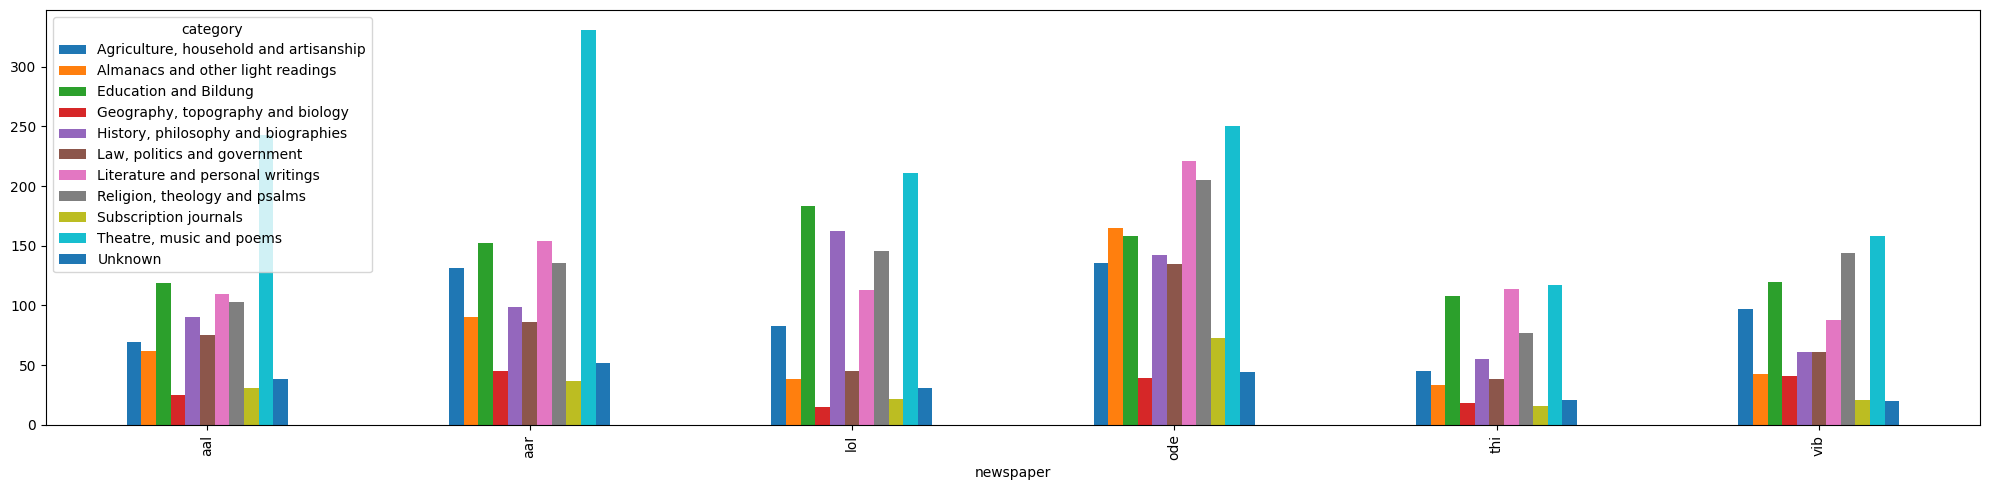

In [36]:
fig, ax = plt.subplots(figsize=(20, 5))  # Create fig and ax together
pivot_df_raw.plot.bar(ax=ax)                # Plot on the specified ax
#ax.legend().remove()                    # Remove the legend (alternative to plt.legend(''))
plt.tight_layout()
plt.show()

In [ ]:
# Normal distribution

# simulate 100 extra data points with the same mean and std for each newspaper

simulated_data = []

for newspaper in pivot_df.index:
    mean_vec = pivot_df.loc[newspaper].values
    std_vec = pivot_df.loc[newspaper].std()

    # Simulate 100 samples per newspaper from a multivariate normal
    # Use a diagonal covariance matrix (no correlation between categories)
    cov = np.diag([std_vec] * len(mean_vec))  # simple isotropic assumption
    samples = np.random.normal(loc=mean_vec, scale=std_vec, size=(100, len(mean_vec)))

    for sample in samples:
        simulated_data.append({
            'newspaper': newspaper,
            **{cat: val for cat, val in zip(pivot_df.columns, sample)}
        })

# 2. Convert to DataFrame
simulated_df = pd.DataFrame(simulated_data)

In [56]:
# Bootstrapping

# Number of bootstrap samples per newspaper
n_samples = 100

simulated_data = []

# Loop over each newspaper
for newspaper in pivot_df.index:
    # Get the actual row (a 1D array of category values)
    original_row = pivot_df.loc[newspaper].values

    # Bootstrap: sample with replacement from the category values (columns)
    # Each sample is a resample of the original category proportions
    samples = np.random.choice(original_row, size=(n_samples, len(original_row)), replace=True)

    for sample in samples:
        simulated_data.append({
            'newspaper': newspaper,
            **{cat: val for cat, val in zip(pivot_df.columns, sample)}
        })

# Convert to DataFrame
simulated_df_boot = pd.DataFrame(simulated_data)

In [31]:
original_row.sum()

854

In [57]:
simulated_df_indexed = simulated_df_boot.set_index('newspaper')

In [58]:
total_df_boot = pd.concat([pivot_df, simulated_df_indexed])

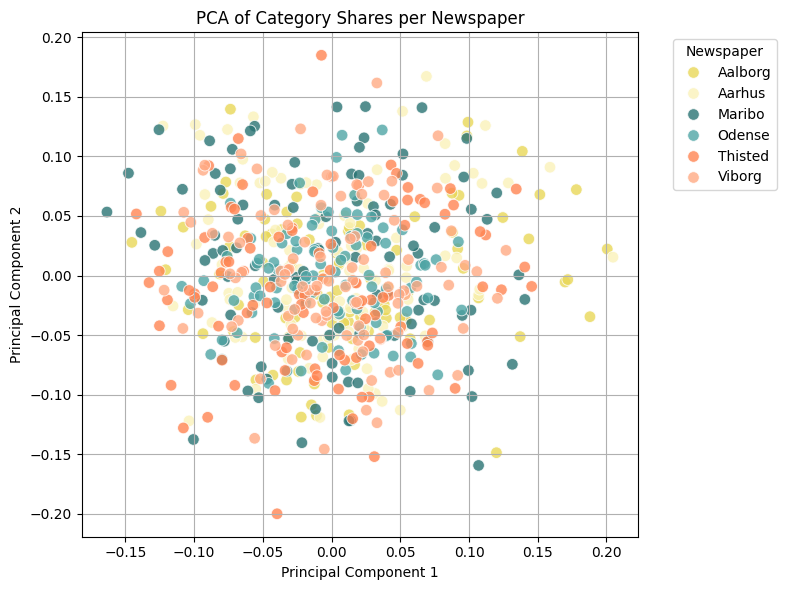

In [ ]:
# Step 3: Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(total_df)

# Step 4: Plot
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=total_df.index)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='newspaper', palette=newspaper_to_color, s=70, alpha=0.8)

# Annotate with newspaper names
#for index, row in pca_df.iterrows():
    #plt.text(row['PC1'], row['PC2'], index, fontsize=9)

plt.title('PCA of Category Shares per Newspaper')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Get original handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Replace labels with custom ones
custom_labels = [legend_labels[label] for label in labels]

# Apply updated legend
plt.legend(handles, custom_labels, title='Newspaper', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend([unique_newspapers])
plt.grid(True)
plt.tight_layout()
plt.show()

/Users/au711514/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


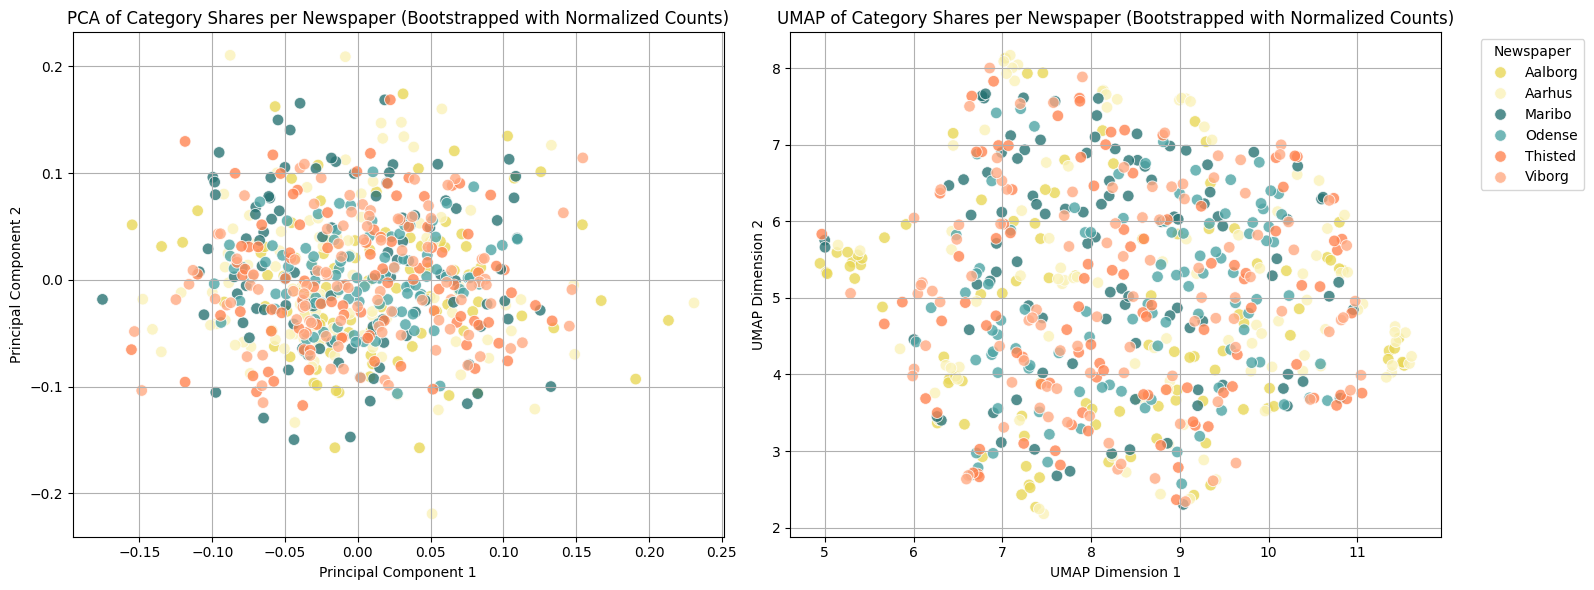

In [60]:
#  NORMALIZED COUNTS

# --- PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(total_df_boot)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=total_df_boot.index)
#pca_df['newspaper'] = total_df['newspaper']  # If not already in index or columns

# --- UMAP ---
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(total_df_boot)  # Drop label column if included
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=total_df_boot.index)
#umap_df['newspaper'] = total_df['newspaper']

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- PCA subplot ---
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='newspaper',
    palette=newspaper_to_color,
    s=70, alpha=0.8,
    ax=axes[0]
)
axes[0].set_title('PCA of Category Shares per Newspaper (Bootstrapped with Normalized Counts)')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].grid(True)
axes[0].legend_.remove()  # remove duplicate legend

# --- UMAP subplot ---
sns.scatterplot(
    data=umap_df,
    x='UMAP1', y='UMAP2',
    hue='newspaper',
    palette=newspaper_to_color,
    s=70, alpha=0.8,
    ax=axes[1]
)
axes[1].set_title('UMAP of Category Shares per Newspaper (Bootstrapped with Normalized Counts)')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')
axes[1].grid(True)

# Unified legend
handles, labels = axes[1].get_legend_handles_labels()
custom_labels = [legend_labels[label] for label in labels]
axes[1].legend(handles, custom_labels, title='Newspaper', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('../figures/PCA_UMAP_boot_norm.pdf', bbox_inches='tight')
plt.show()

In [116]:
total_df_boot_raw_norm = total_df_boot_raw.div(total_df_boot_raw.sum(axis=1), axis=0)

In [117]:
total_df_boot_raw_norm

,"Agriculture, household and artisanship",Almanacs and other light readings,Education and Bildung,"Geography, topography and biology","History, philosophy and biographies","Law, politics and government",Literature and personal writings,"Religion, theology and psalms",Subscription journals,"Theatre, music and poems",Unknown
newspaper,,,,,,,,,,,
aal,0.071503,0.064249,0.123316,0.025907,0.093264,0.077720,0.113990,0.106736,0.032124,0.251813,0.039378
aar,0.099772,0.068545,0.115765,0.034273,0.075400,0.065499,0.117289,0.103580,0.028180,0.252094,0.039604
lol,0.079123,0.036225,0.174452,0.014299,0.154433,0.042898,0.107722,0.139180,0.020972,0.201144,0.029552
ode,0.086735,0.105230,0.100765,0.024872,0.090561,0.086097,0.140944,0.130740,0.046556,0.159439,0.028061
thi,0.070093,0.051402,0.168224,0.028037,0.085670,0.059190,0.177570,0.119938,0.024922,0.182243,0.032710
...,...,...,...,...,...,...,...,...,...,...,...
vib,0.122075,0.160732,0.146490,0.098678,0.062055,0.043744,0.062055,0.122075,0.021363,0.098678,0.062055
vib,0.057181,0.081117,0.026596,0.117021,0.026596,0.159574,0.081117,0.159574,0.210106,0.026596,0.054521
vib,0.080581,0.158520,0.080581,0.026420,0.080581,0.158520,0.116248,0.056803,0.056803,0.158520,0.026420


/Users/au711514/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


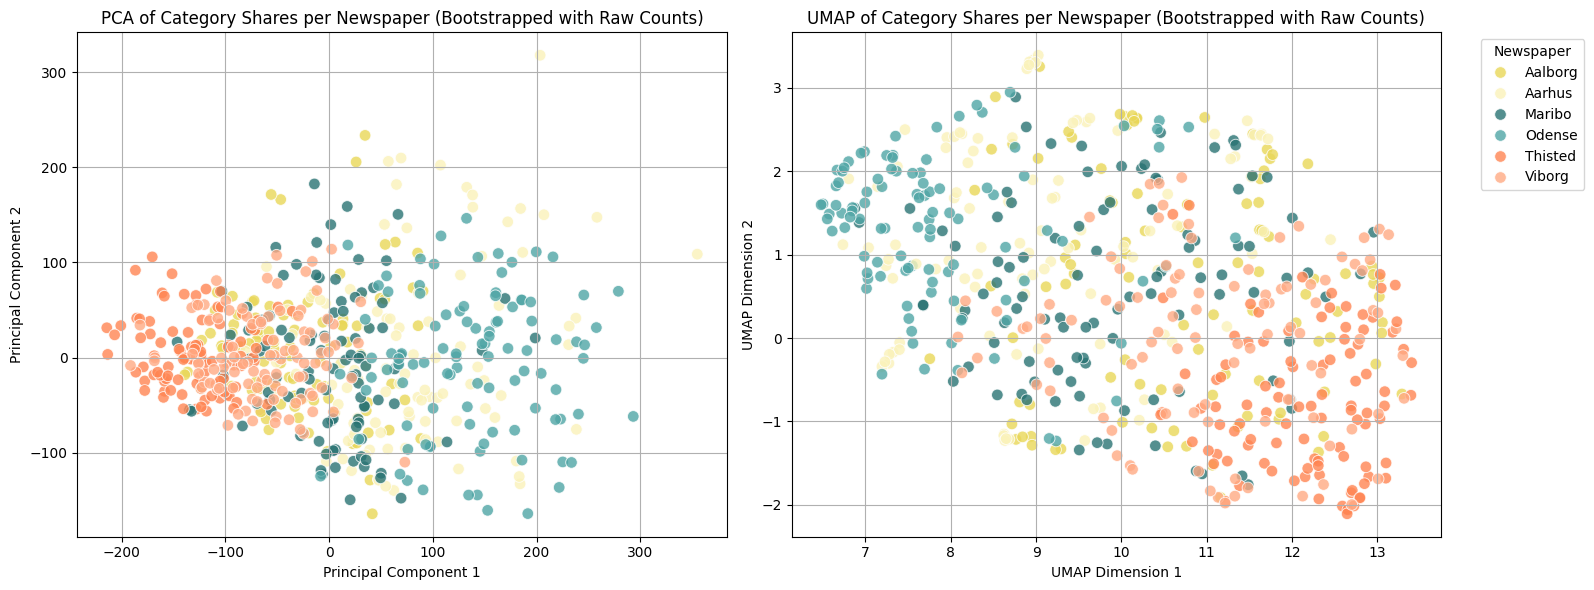

In [ ]:
# RAW COUNTS

# --- PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(total_df_boot_raw)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=total_df_boot_raw.index)
#pca_df['newspaper'] = total_df['newspaper']  # If not already in index or columns

# --- UMAP ---
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(total_df_boot_raw)  # Drop label column if included
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=total_df_boot_raw.index)
#umap_df['newspaper'] = total_df['newspaper']

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- PCA subplot ---
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='newspaper',
    palette=newspaper_to_color,
    s=70, alpha=0.8,
    ax=axes[0]
)
axes[0].set_title('PCA of Category Shares per Newspaper (Bootstrapped with Raw Counts)')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].grid(True)
axes[0].legend_.remove()  # remove duplicate legend

# --- UMAP subplot ---
sns.scatterplot(
    data=umap_df,
    x='UMAP1', y='UMAP2',
    hue='newspaper',
    palette=newspaper_to_color,
    s=70, alpha=0.8,
    ax=axes[1]
)
axes[1].set_title('UMAP of Category Shares per Newspaper (Bootstrapped with Raw Counts)')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')
axes[1].grid(True)

# Unified legend
handles, labels = axes[1].get_legend_handles_labels()
custom_labels = [legend_labels[label] for label in labels]
axes[1].legend(handles, custom_labels, title='Newspaper', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('../figures/PCA_UMAP_boot_raw.pdf', bbox_inches='tight')
plt.show()

/Users/au711514/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


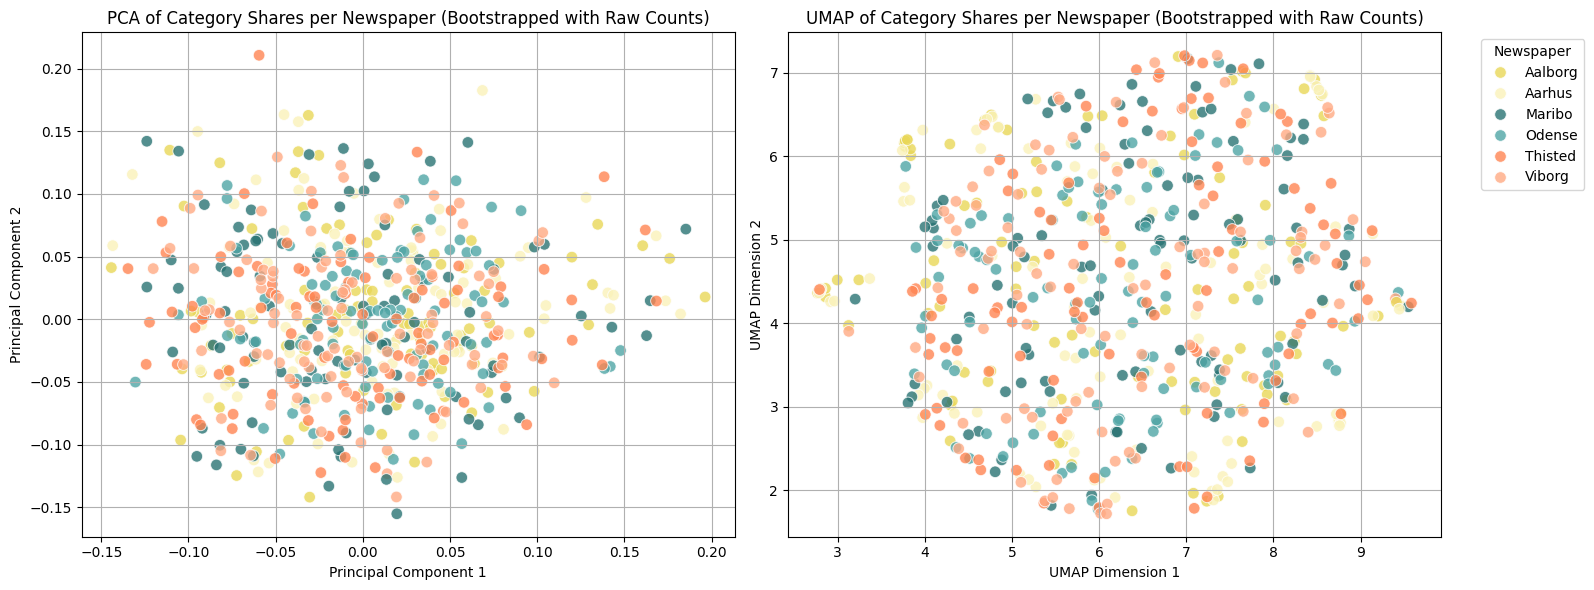

In [118]:
# RAW COUNTS

# --- PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(total_df_boot_raw_norm)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=total_df_boot_raw_norm.index)
#pca_df['newspaper'] = total_df['newspaper']  # If not already in index or columns

# --- UMAP ---
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(total_df_boot_raw_norm)  # Drop label column if included
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=total_df_boot_raw_norm.index)
#umap_df['newspaper'] = total_df['newspaper']

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- PCA subplot ---
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='newspaper',
    palette=newspaper_to_color,
    s=70, alpha=0.8,
    ax=axes[0]
)
axes[0].set_title('PCA of Category Shares per Newspaper (Bootstrapped with Raw Counts)')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].grid(True)
axes[0].legend_.remove()  # remove duplicate legend

# --- UMAP subplot ---
sns.scatterplot(
    data=umap_df,
    x='UMAP1', y='UMAP2',
    hue='newspaper',
    palette=newspaper_to_color,
    s=70, alpha=0.8,
    ax=axes[1]
)
axes[1].set_title('UMAP of Category Shares per Newspaper (Bootstrapped with Raw Counts)')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')
axes[1].grid(True)

# Unified legend
handles, labels = axes[1].get_legend_handles_labels()
custom_labels = [legend_labels[label] for label in labels]
axes[1].legend(handles, custom_labels, title='Newspaper', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
#plt.savefig('../figures/PCA_UMAP_boot_raw.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# dendrogram
# jensen shannon

In [66]:
def plot_newspaper_dendrogram(total_df, newspaper_to_color, figsize=(30,5)):
    """
    Plot a dendrogram of real + simulated newspapers using your custom palette.
    Assumes total_df has a 'newspaper' column.
    """
    # Extract labels
    newspaper_labels = total_df['newspaper']

    # Compute cosine distances
    df_vectors = total_df.drop(columns=['newspaper'])
    cosine_dist_matrix = cosine_distances(df_vectors.values)
    Z = linkage(cosine_dist_matrix, method='ward')

    # Plot dendrogram
    sns.set_style('whitegrid')
    plt.figure(figsize=figsize)
    dend = dendrogram(
        Z,
        labels=newspaper_labels.tolist(),
        leaf_font_size=8,
        color_threshold=0,
        above_threshold_color='black'
    )

    # Color tick labels
    ax = plt.gca()
    xticklabels = ax.get_xticklabels()
    used_colors = {}

    for tick in xticklabels:
        label = tick.get_text()
        color = newspaper_to_color.get(label, 'black')
        tick.set_color(color)
        used_colors[label] = color

    # Legend (one entry per newspaper)
    legend_handles = [
        Patch(facecolor=color, label=label) for label, color in newspaper_to_color.items()
    ]
    ax.legend(handles=legend_handles, loc='upper right', title='Newspaper')

    plt.xlabel("Cosine Distance")
    plt.title("Dendrogram of Newspapers with Simulated Samples")
    plt.tight_layout()
    plt.show()

total_df_flat = total_df.reset_index()
plot_newspaper_dendrogram(total_df_flat, newspaper_to_color)

NameError: name 'linkage' is not defined

In [ ]:
pivot_df_flat = pivot_df.reset_index()
#plot_newspaper_dendrogram(pivot_df_flat, newspaper_to_color, figsize=(5,2))

NameError: name 'linkage' is not defined

In [63]:
def plot_bar_dendrogram_newspapers(df, newspaper_to_color, title="Dendrogram of Newspapers (Simulated and Real)", figsize=(20, 5)):
    """
    Plot a horizontal bar-colored dendrogram of newspapers based on cosine distances.
    
    Parameters:
    - df: DataFrame with 'newspaper' column and only numeric category columns.
    - newspaper_to_color: dict mapping each newspaper to a color.
    - title: plot title.
    - figsize: tuple with figure size.
    """
    # Extract labels
    newspaper_labels = df['newspaper'].values
    col_colors = pd.Series(newspaper_labels).map(newspaper_to_color).values

    # Prepare data matrix for cosine distance (exclude 'newspaper' column)
    matrix = df.drop(columns=['newspaper']).values
    dist_matrix = cosine_distances(matrix)

    # Compute linkage
    Z = linkage(dist_matrix, method='ward')

    # Plot clustermap with colored bars
    sns.set_theme(style="white")
    g = sns.clustermap(
        matrix.T,  # transpose to match color bars correctly
        col_linkage=Z,
        row_cluster=False,
        col_colors=col_colors,
        figsize=figsize,
        dendrogram_ratio=(0.01, 0.9),
        colors_ratio=0.04
    )

    # Remove heatmap and colorbar
    g.ax_heatmap.remove()
    g.cax.remove()

    # Build legend from used newspapers
    handles = [Patch(color=color, label=paper) for paper, color in newspaper_to_color.items()]
    g.ax_col_dendrogram.legend(handles=handles, loc='upper right', title='Newspaper', fontsize=9)

    # Add label and title
    g.fig.text(0.02, 0.6, "Cosine Distance", va='center', rotation='vertical', fontsize=12)
    g.fig.suptitle(title, y=1.02, fontsize=14)

    plt.show()

In [69]:
plot_bar_dendrogram_newspapers(total_df_flat, newspaper_to_color)

NameError: name 'linkage' is not defined

In [65]:
matrix = pivot_df_flat.drop(columns=['newspaper']).values
dist_matrix = cosine_distances(matrix)

In [291]:
dist_matrix

array([[0.        , 0.00557598, 0.04628976, 0.04940853, 0.045392  ,
        0.0470104 ],
       [0.00557598, 0.        , 0.06043659, 0.05042961, 0.05019813,
        0.04161362],
       [0.04628976, 0.06043659, 0.        , 0.07521748, 0.0416648 ,
        0.04710549],
       [0.04940853, 0.05042961, 0.07521748, 0.        , 0.04317018,
        0.04375911],
       [0.045392  , 0.05019813, 0.0416648 , 0.04317018, 0.        ,
        0.04535018],
       [0.0470104 , 0.04161362, 0.04710549, 0.04375911, 0.04535018,
        0.        ]])

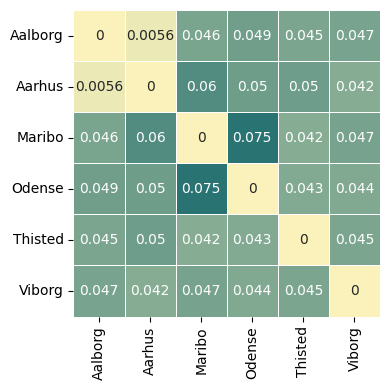

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from matplotlib.colors import LinearSegmentedColormap

def plot_distance_heatmap(df, title="Cosine Distance Between Category Distributions in Newspapers"):
    """
    Plot a heatmap of the cosine distance matrix for all newspaper vectors.
    Assumes 'newspaper' column exists in the dataframe.
    """
    # Extract vectors and labels
    labels = ['Aalborg', 'Aarhus', 'Maribo', 'Odense', 'Thisted', 'Viborg'] #df['newspaper'].values
    matrix = df.drop(columns=['newspaper']).values

    # Compute cosine distance matrix
    dist_matrix = cosine_distances(matrix)

    # Create DataFrame for labeling
    dist_df = pd.DataFrame(dist_matrix, index=labels, columns=labels)

    # Define custom colormap from yellow to teal
    custom_cmap = LinearSegmentedColormap.from_list("yellow_to_teal", ['#FAF2BA', '#297373'])

    # Plot heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        dist_df,
        cmap=custom_cmap,
        cbar=False,
        square=True,
        xticklabels=True,
        yticklabels=True,
        #cbar_kws={'label': 'Cosine Distance'},
        annot=True,
        linewidths=0.5
    )
    #plt.title(title, fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('../figures/heatmap_cosine.pdf', bbox_inches='tight')
    plt.show()

# Usage
plot_distance_heatmap(pivot_df_flat)

   #  '#E9D758', '#FAF2BA', # yellows
   #  '#297373', '#4FA5A5', # teals
# color= '#FF8552', '#FFAA84' # corals

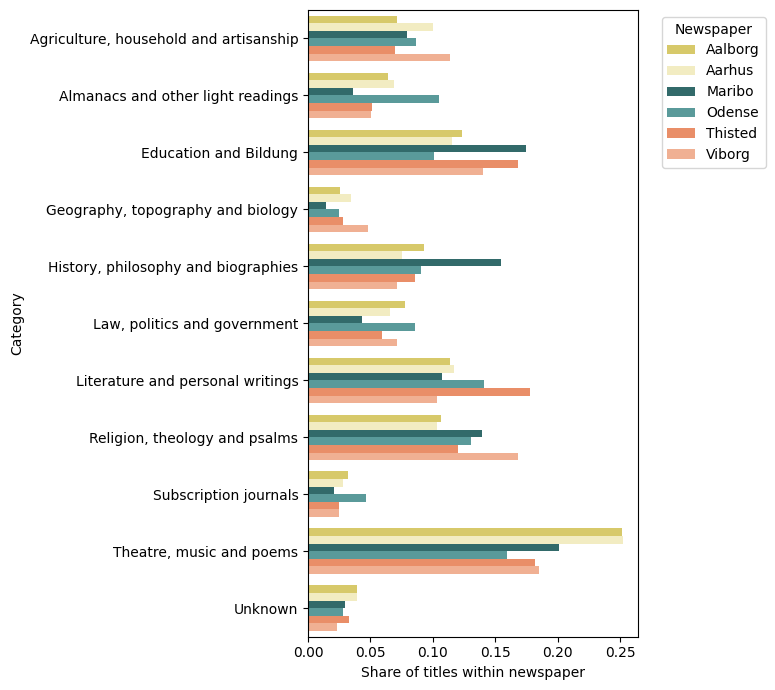

In [198]:
plt.figure(figsize=(8, 7))

legend_labels = {'aal': 'Aalborg',
                 'aar': 'Aarhus',
                 'lol': 'Maribo',
                 'ode': 'Odense',
                 'thi': 'Thisted',
                 'vib': 'Viborg'}

sns.barplot(
    data=category_shares,
    y='category',
    x='category_share',
    hue='newspaper',
    orient='h',
    palette=newspaper_to_color  # ✅ this applies your custom colors
)

plt.xlabel('Share of titles within newspaper')
plt.ylabel('Category')
#plt.title('Category distribution per newspaper')

# Get original handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Replace labels with custom ones
custom_labels = [legend_labels[label] for label in labels]

# Apply updated legend
plt.legend(handles, custom_labels, title='Newspaper', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../figures/horizontal_bars_cats.pdf', bbox_inches='tight')
plt.show()